Train years: [2000, 2001, 2002] ... [2014, 2015, 2016]
Valid years: [2017, 2018, 2019]
Test  years: [2020, 2021, 2022, 2023]
Shapes -> Train: (646, 12, 3), Valid: (102, 12, 3), Test: (136, 12, 3)
Month-01 feature triplet: ['ndvi_01', 'tmax_01', 'precip_01']  | sample[0,0,:] ->  [0.8317907  0.69668025 0.38624227]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 12, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     17,408 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 73)        │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,736 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3517.8359 - mae: 56.5229 - val_loss: 3965.1116 - val_mae: 60.3196
Epoch 2/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3293.9058 - mae: 54.4732 - val_loss: 3171.5635 - val_mae: 53.0976
Epoch 3/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2091.9509 - mae: 41.5911 - val_loss: 1044.5294 - val_mae: 27.5253
Epoch 4/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 634.1011 - mae: 20.1044 - val_loss: 375.5248 - val_mae: 15.3607
Epoch 5/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 348.3734 - mae: 14.7597 - val_loss: 328.8746 - val_mae: 14.1970
Epoch 6/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 303.6238 - mae: 13.9516 - val_loss: 345.2667 - val_mae: 14.6976
Epoch 7/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 333.6380 - mae: 14.7371 - val_loss: 344.5882 - val_mae: 14.7037
Epoch 8/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 307.5291 - mae: 14.1074 - val_loss: 332.6660 - val_mae: 14.4302
Epoch 9/1

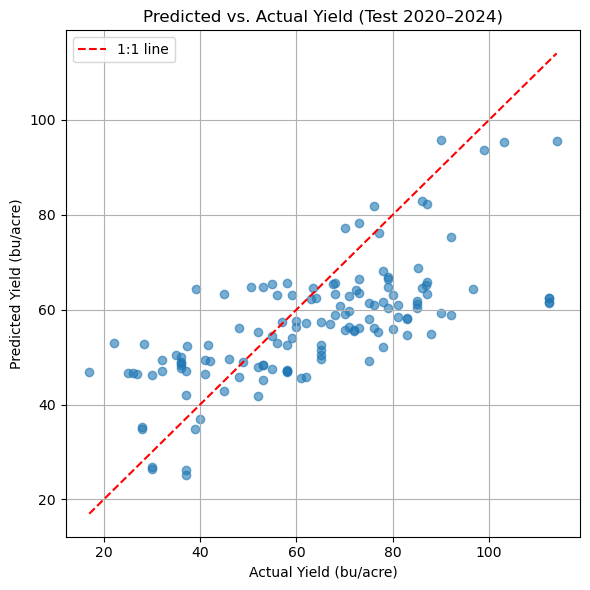

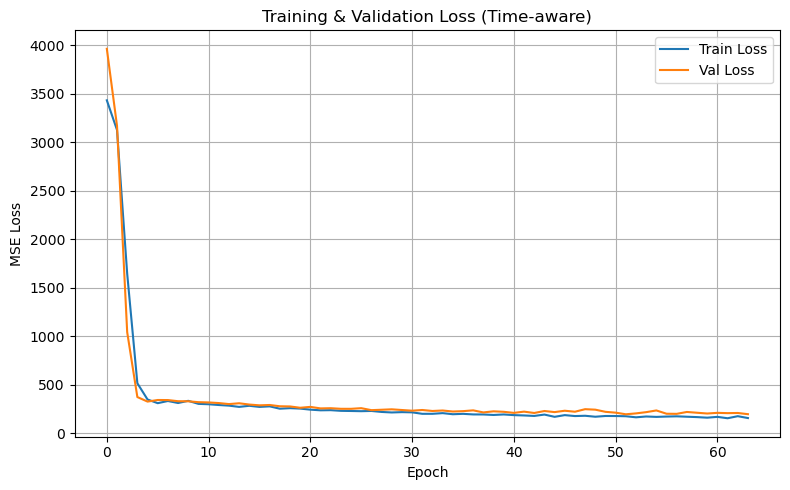

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

# ========= 1) Data Loading =========
df = pd.read_csv("../data/lstm_input_states_cleaned.csv")
assert "year" in df.columns, "Data must contain 'year' column"
df["year"] = df["year"].astype(int)

target_col = "yield"

# 12 months × 3 variables (monthly aligned)
months = [f"{m:02d}" for m in range(1, 13)]
feat_by_month = [[f"ndvi_{m}", f"tmax_{m}", f"precip_{m}"] for m in months]

# Static features
static_cols = [c for c in ["ph", "ocd", "clay", "sand", "silt", "bd", "planting_doy", "harvest_doy", "irr_flag"] if c in df.columns]

# Basic cleaning
df = df.dropna(subset=[target_col]).copy()
# Fill missing values with 0 (for static/sequence features)
seq_needed = [c for cols in feat_by_month for c in cols]
for c in seq_needed + static_cols:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")
df[seq_needed + static_cols] = df[seq_needed + static_cols].fillna(0)

# ========= 2) Year-based Split =========
train_mask = df["year"].between(2000, 2019)
test_mask  = df["year"].between(2020, 2024)

val_years = [2017, 2018, 2019]
val_mask = train_mask & df["year"].isin(val_years)
train_core_mask = train_mask & ~val_mask
if val_mask.sum() == 0:
    yrs = sorted(df.loc[train_mask, "year"].unique())
    k = max(1, int(round(len(yrs)*0.2)))
    val_years = yrs[-k:]
    val_mask = train_mask & df["year"].isin(val_years)
    train_core_mask = train_mask & ~val_mask
    print(f"[Info] Using last {k} years of training period as validation set: {val_years}")

print("Train years:", sorted(df.loc[train_core_mask, "year"].unique())[:3], "...", sorted(df.loc[train_core_mask, "year"].unique())[-3:])
print("Valid years:", sorted(df.loc[val_mask, "year"].unique()))
print("Test  years:", sorted(df.loc[test_mask, "year"].unique()))

# ========= 3) Construct (N, 12, 3) sequence tensor (stacked by month) =========
def make_seq_tensor(frame):
    # Shape: (N, 12, 3) where 3 corresponds to [ndvi, tmax, precip]
    seq_list = [frame[cols].values for cols in feat_by_month]  # 12 arrays of (N, 3)
    X_seq = np.stack(seq_list, axis=1)  # (N, 12, 3)
    return X_seq.astype(np.float32)

def make_arrays(mask):
    sub = df.loc[mask]
    X_seq = make_seq_tensor(sub)
    X_sta = sub[static_cols].values.astype(np.float32) if static_cols else np.zeros((len(sub),0), np.float32)
    y     = sub[target_col].values.astype(np.float32)
    return X_seq, X_sta, y, sub

X_seq_tr, X_sta_tr, y_tr, df_tr = make_arrays(train_core_mask)
X_seq_va, X_sta_va, y_va, df_va = make_arrays(val_mask)
X_seq_te, X_sta_te, y_te, df_te = make_arrays(test_mask)

print(f"Shapes -> Train: {X_seq_tr.shape}, Valid: {X_seq_va.shape}, Test: {X_seq_te.shape}")

# Key diagnostic: Verify that the first sample's January is aligned as [ndvi_01, tmax_01, precip_01]
debug_cols = feat_by_month[0]
print("Month-01 feature triplet:", debug_cols, " | sample[0,0,:] -> ", X_seq_tr[0,0,:])

# ========= 4) Standardization (using training set statistics only) =========
# Sequence three channels: Apply z-score along channel dimension (across all training samples and months)
c = X_seq_tr.shape[2]
seq_mean = X_seq_tr.reshape(-1, c).mean(axis=0)
seq_std  = X_seq_tr.reshape(-1, c).std(axis=0) + 1e-8
def norm_seq(X):
    return (X - seq_mean) / seq_std
X_seq_tr = norm_seq(X_seq_tr)
X_seq_va = norm_seq(X_seq_va)
X_seq_te = norm_seq(X_seq_te)

# Static features: Standardize
if X_sta_tr.shape[1] > 0:
    sta_scaler = StandardScaler().fit(X_sta_tr)
    X_sta_tr = sta_scaler.transform(X_sta_tr)
    X_sta_va = sta_scaler.transform(X_sta_va)
    X_sta_te = sta_scaler.transform(X_sta_te)

# ========= 5) Model Architecture =========
seq_input = Input(shape=(12, X_seq_tr.shape[2]), name="seq_input")
lstm_out  = LSTM(64)(seq_input)
dropout_seq = Dropout(0.2)(lstm_out)

static_input = Input(shape=(X_sta_tr.shape[1],), name="static_input")
merged = concatenate([dropout_seq, static_input]) if X_sta_tr.shape[1] > 0 else dropout_seq
dense1 = Dense(64, activation="relu")(merged)
dropout_comb = Dropout(0.2)(dense1)
output = Dense(1)(dropout_comb)

model = Model(inputs=[seq_input, static_input] if X_sta_tr.shape[1]>0 else [seq_input],
              outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# ========= 6) Training (with time-aware validation set) =========
early_stop = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
history = model.fit(
    {"seq_input": X_seq_tr, "static_input": X_sta_tr} if X_sta_tr.shape[1]>0 else {"seq_input": X_seq_tr},
    y_tr,
    validation_data=(
        ({"seq_input": X_seq_va, "static_input": X_sta_va} if X_sta_va.shape[1]>0 else {"seq_input": X_seq_va}),
        y_va
    ),
    epochs=120,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ========= 7) Test Evaluation =========
y_pred = model.predict({"seq_input": X_seq_te, "static_input": X_sta_te} if X_sta_te.shape[1]>0 else {"seq_input": X_seq_te},
                       verbose=0).ravel()

rmse = float(np.sqrt(mean_squared_error(y_te, y_pred)))
mae  = float(mean_absolute_error(y_te, y_pred))
r2   = float(r2_score(y_te, y_pred))

print("\n=== Test (2020–2024) ===")
print(f"RMSE: {rmse:.2f} bu/acre")
print(f"MAE : {mae:.2f} bu/acre")
print(f"R²  : {r2:.3f}")

# ========= 8) Yearly Metrics =========
out = pd.DataFrame({"year": df_te["year"].values, "y_true": y_te, "y_pred": y_pred})
def rmse_vec(a, b): return float(np.sqrt(np.mean((a-b)**2)))
year_metrics = (out.groupby("year")
                  .apply(lambda g: pd.Series({
                      "RMSE": rmse_vec(g["y_true"].values, g["y_pred"].values),
                      "MAE" : mean_absolute_error(g["y_true"].values, g["y_pred"].values),
                      "R2"  : r2_score(g["y_true"].values, g["y_pred"].values) if g["y_true"].nunique()>1 else np.nan
                  }))
               )
print("\nPer-year metrics (Test 2020–2024):")
print(year_metrics.round(3))

# ========= 9) Visualization =========
plt.figure(figsize=(6,6))
plt.scatter(out["y_true"], out["y_pred"], alpha=0.6)
mmin, mmax = float(np.min([out["y_true"].min(), out["y_pred"].min()])), float(np.max([out["y_true"].max(), out["y_pred"].max()]))
plt.plot([mmin, mmax],[mmin, mmax],'r--',label="1:1 line")
plt.xlabel("Actual Yield (bu/acre)")
plt.ylabel("Predicted Yield (bu/acre)")
plt.title("Predicted vs. Actual Yield (Test 2020–2024)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss (Time-aware)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

Apply MinMaxScaler standardization to yield;
After the model is output, inverse_transform is executed to restore it to the actual unit (bu/acre)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1024 - mae: 0.2513 - val_loss: 0.0276 - val_mae: 0.1354
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0547 - mae: 0.1807 - val_loss: 0.0144 - val_mae: 0.0898
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0455 - mae: 0.1709 - val_loss: 0.0158 - val_mae: 0.0984
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0316 - mae: 0.1412 - val_loss: 0.0151 - val_mae: 0.1047
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0336 - mae: 0.1429 - val_loss: 0.0123 - val_mae: 0.0884
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266 - mae: 0.1253 - val_loss: 0.0116 - val_mae: 0.0893
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223 - mae: 0.1149 - val_loss: 0.0132 - val_mae: 0.0964
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209 - mae: 0.1107 - val_loss: 0.0117 - val_mae: 0.0920
Epoch 9/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.01

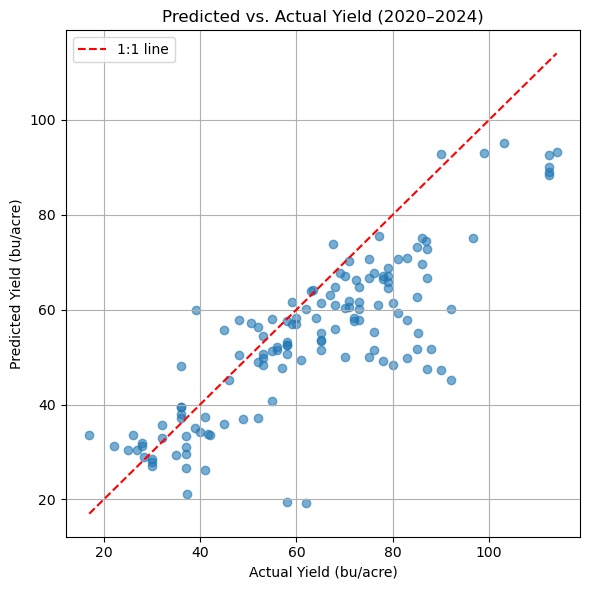

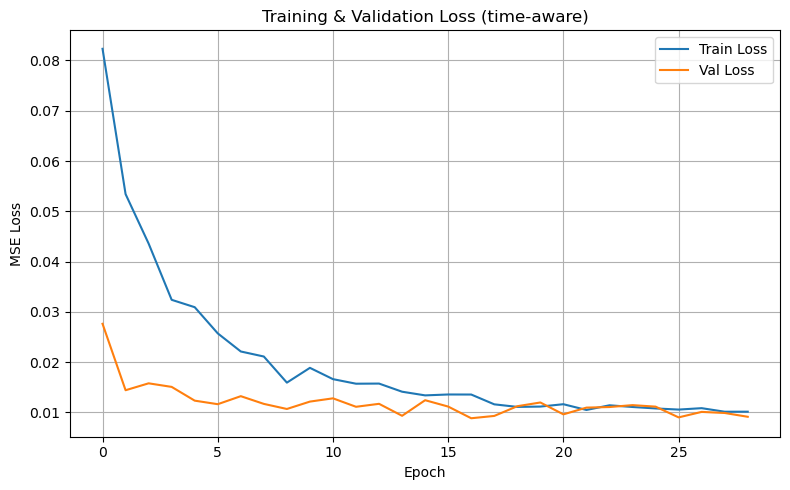

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

# ---------------- 1) Read Data & Split ----------------
df = pd.read_csv("../data/lstm_input_states_cleaned.csv")
assert "year" in df.columns and "yield" in df.columns
df["year"] = df["year"].astype(int)
target_col = "yield"

static_cols_all = ["ph","ocd","clay","sand","silt","bd","irr_flag","planting_doy","harvest_doy"]
static_cols = [c for c in static_cols_all if c in df.columns]

def month_triplet(m):
    mm = f"{m:02d}"
    c1 = [f"ndvi_{mm}", f"tmax_{mm}", f"precip_{mm}"]
    if all(c in df.columns for c in c1): return c1
    c2 = [f"ndvi_{m}", f"tmax_{m}", f"precip_{m}"]
    if all(c in df.columns for c in c2): return c2
    raise ValueError(f"Missing columns: {c1} or {c2}")

feat_by_month = [month_triplet(m) for m in range(1,13)]
need_cols = [c for cols in feat_by_month for c in cols] + static_cols
df = df.dropna(subset=[target_col]).copy()
df[need_cols] = df[need_cols].fillna(0)

train_mask = df["year"].between(2000, 2019)
test_mask  = df["year"].between(2020, 2024)
val_mask   = train_mask & df["year"].isin([2017, 2018, 2019])
train_core_mask = train_mask & ~val_mask
if val_mask.sum() == 0:
    yrs = sorted(df.loc[train_mask, "year"].unique())
    k = max(1, int(round(len(yrs)*0.2)))
    val_mask = train_mask & df["year"].isin(yrs[-k:])
    train_core_mask = train_mask & ~val_mask

def make_seq(frame):
    blocks = [frame[cols].values for cols in feat_by_month]  # 12×(N,3)
    return np.stack(blocks, axis=1).astype(np.float32)      # (N,12,3)

def pack(mask):
    sub = df.loc[mask]
    X_seq = make_seq(sub)
    X_sta = sub[static_cols].values.astype(np.float32) if static_cols else np.zeros((len(sub),0),np.float32)
    y     = sub[target_col].values.astype(np.float32)
    return X_seq, X_sta, y, sub

X_seq_tr, X_sta_tr, y_tr_raw, df_tr = pack(train_core_mask)
X_seq_va, X_sta_va, y_va_raw, df_va = pack(val_mask)
X_seq_te, X_sta_te, y_te_raw, df_te = pack(test_mask)

# ---------------- 2) Standardization (Using Training Period Only) ----------------
# Z-score normalization for sequence three channels (across all training samples and months)
C = X_seq_tr.shape[2]
seq_mean = X_seq_tr.reshape(-1, C).mean(axis=0)
seq_std  = X_seq_tr.reshape(-1, C).std(axis=0) + 1e-8
def norm_seq(X): return (X - seq_mean) / seq_std
X_seq_tr, X_seq_va, X_seq_te = map(norm_seq, [X_seq_tr, X_seq_va, X_seq_te])

# Z-score normalization for static features
if X_sta_tr.shape[1] > 0:
    sta_scaler = StandardScaler().fit(X_sta_tr)
    X_sta_tr = sta_scaler.transform(X_sta_tr)
    X_sta_va = sta_scaler.transform(X_sta_va)
    X_sta_te = sta_scaler.transform(X_sta_te)

# MinMax scaling for target (using both training and validation periods for more stable fitting)
y_scaler = MinMaxScaler().fit(np.concatenate([y_tr_raw, y_va_raw]).reshape(-1,1))
y_tr = y_scaler.transform(y_tr_raw.reshape(-1,1)).ravel()
y_va = y_scaler.transform(y_va_raw.reshape(-1,1)).ravel()

# ---------------- 3) Model ----------------
seq_input = Input(shape=(12, X_seq_tr.shape[2]), name="seq_input")
lstm_out  = LSTM(96)(seq_input)
drop_seq  = Dropout(0.3)(lstm_out)

static_input = Input(shape=(X_sta_tr.shape[1],), name="static_input")
merged = concatenate([drop_seq, static_input]) if X_sta_tr.shape[1]>0 else drop_seq
dense1 = Dense(96, activation="relu")(merged)
drop_c = Dropout(0.3)(dense1)
output = Dense(1)(drop_c)

model = Model(inputs=[seq_input, static_input] if X_sta_tr.shape[1]>0 else [seq_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

early = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
model.fit(
    {"seq_input": X_seq_tr, "static_input": X_sta_tr} if X_sta_tr.shape[1]>0 else {"seq_input": X_seq_tr},
    y_tr,
    validation_data=(
        ({"seq_input": X_seq_va, "static_input": X_sta_va} if X_sta_va.shape[1]>0 else {"seq_input": X_seq_va}),
        y_va
    ),
    epochs=200, batch_size=32, callbacks=[early], verbose=1
)

# ---------------- 4) Test Evaluation ----------------
y_pred_scaled = model.predict(
    {"seq_input": X_seq_te, "static_input": X_sta_te} if X_sta_te.shape[1]>0 else {"seq_input": X_seq_te},
    verbose=0
).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_true = y_te_raw

rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
mae  = float(mean_absolute_error(y_true, y_pred))
r2   = float(r2_score(y_true, y_pred))
print("\n=== Test (2020–2024) ===")
print(f"RMSE: {rmse:.2f} bu/acre")
print(f"MAE : {mae:.2f} bu/acre")
print(f"R²  : {r2:.3f}")

# ---------------- 5) Yearly Metrics ----------------
out = pd.DataFrame({"year": df_te["year"].values, "y_true": y_true, "y_pred": y_pred})
def rmse_vec(a,b): return float(np.sqrt(np.mean((a-b)**2)))
year_metrics = (out.groupby("year")
                 .apply(lambda g: pd.Series({
                     "RMSE": rmse_vec(g["y_true"].values, g["y_pred"].values),
                     "MAE" : mean_absolute_error(g["y_true"].values, g["y_pred"].values),
                     "R2"  : r2_score(g["y_true"].values, g["y_pred"].values) if g["y_true"].nunique()>1 else np.nan
                 })))
print("\nPer-year metrics (Test 2020–2024):")
print(year_metrics.round(3))

# ---------------- 6) Naive Baseline (Mean Yield per State in Training Period) ----------------
# Only run this baseline if 'state' column exists; otherwise skip
if "state" in df.columns:
    mean_by_state = df.loc[train_mask].groupby("state")[target_col].mean()
    base = df_te[["state"]].copy()
    base["y_pred_base"] = base["state"].map(mean_by_state).fillna(mean_by_state.mean()).values
    base_rmse = rmse_vec(y_true, base["y_pred_base"].values)
    base_r2   = r2_score(y_true, base["y_pred_base"].values)
    print(f"\nNaive baseline (train-state-mean) -> RMSE: {base_rmse:.2f}, R²: {base_r2:.3f}")

# ---------------- 7) Plots ----------------
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
mmin, mmax = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
plt.plot([mmin,mmax],[mmin,mmax],'r--',label="1:1 line")
plt.xlabel("Actual Yield (bu/acre)"); plt.ylabel("Predicted Yield (bu/acre)")
plt.title("Predicted vs. Actual Yield (2020–2024)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(model.history.history["loss"], label="Train Loss")
plt.plot(model.history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss (time-aware)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

Currently, LSTM mainly focuses on fitting the "average differences across states" and does not pay attention to interannual anomalies. So it's normal for the baseline (train-state-mean) to be greater than the LSTM.
The most reliable modification: Change it to "State Mean anomaly Prediction"
Idea: Calculate the historical average μ_state of each state using the training period; The model only learns the interannual anomaly of y - μ_state. Add μ_state(test) back when making predictions. This way, it can naturally "exceed the state average baseline" while maintaining the rigor of extrapolation of time.


Shapes -> Train: (646, 12, 3), Valid: (102, 12, 3), Test: (136, 12, 3)
Check month-1 triplet sample: ['ndvi_01', 'tmax_01', 'precip_01'] -> [0.8317907  0.69668025 0.38624227]
Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 34.3924 - mae: 5.1911 - val_loss: 65.7214 - val_mae: 6.8150
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 34.0964 - mae: 5.1599 - val_loss: 67.1806 - val_mae: 6.9048
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 34.0942 - mae: 5.1567 - val_loss: 68.1099 - val_mae: 6.9595
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 33.9083 - mae: 5.1522 - val_loss: 69.0773 - val_mae: 7.0042
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 33.8559 - mae: 5.1548 - val_loss: 69.2490 - val_mae: 7.0103
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 33.7433 - mae: 5.1430 - val_loss: 69.3886 - val_mae: 7.0263
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33.5114 - mae: 5.1214 - val_loss: 69.3148 - val_m

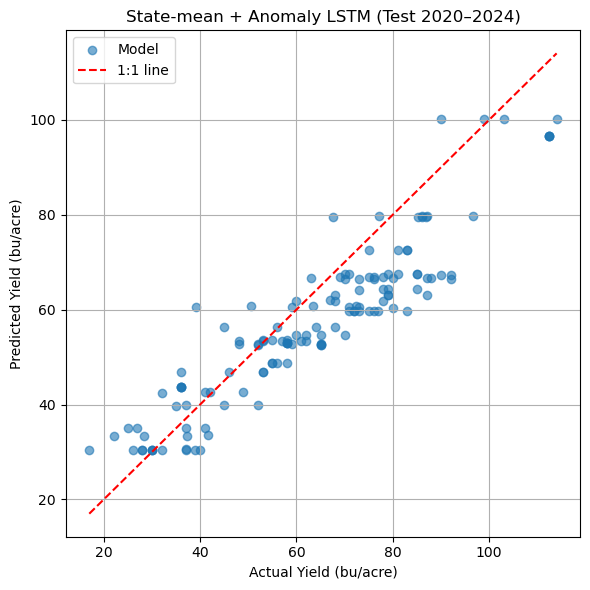

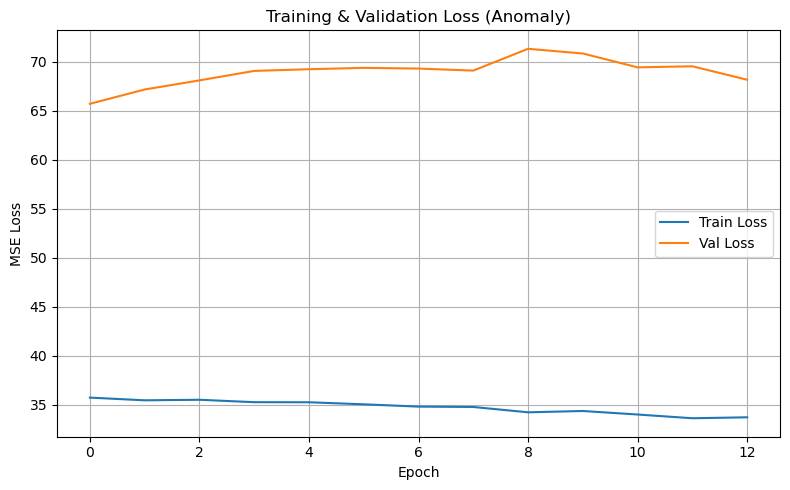

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

# =============== 1) Read Data ===============
df = pd.read_csv("../data/lstm_input_states_cleaned.csv")
assert {"year","yield","state"}.issubset(df.columns), "Requires year, yield, state columns"
df["year"] = df["year"].astype(int)

target_col = "yield"
static_cols_all = ["ph","ocd","clay","sand","silt","bd","irr_flag","planting_doy","harvest_doy"]
static_cols = [c for c in static_cols_all if c in df.columns]

# Construct 12×3 monthly sequence column names ([ndvi_m, tmax_m, precip_m])
def month_triplet(m):
    mm = f"{m:02d}"
    c1 = [f"ndvi_{mm}", f"tmax_{mm}", f"precip_{mm}"]
    if all(c in df.columns for c in c1): return c1
    c2 = [f"ndvi_{m}", f"tmax_{m}", f"precip_{m}"]
    if all(c in df.columns for c in c2): return c2
    raise ValueError(f"Missing required columns for month {m}")

feat_by_month = [month_triplet(m) for m in range(1,13)]
seq_cols = [c for cols in feat_by_month for c in cols]
need_cols = seq_cols + static_cols
df = df.dropna(subset=[target_col]).copy()
df[need_cols] = df[need_cols].fillna(0)

# =============== 2) Temporal Split ===============
train_mask = df["year"].between(2000, 2019)
test_mask  = df["year"].between(2020, 2024)
val_mask   = train_mask & df["year"].isin([2017, 2018, 2019])
train_core_mask = train_mask & ~val_mask
if val_mask.sum() == 0:
    yrs = sorted(df.loc[train_mask,"year"].unique())
    k = max(1, int(round(len(yrs)*0.2)))
    val_mask = train_mask & df["year"].isin(yrs[-k:])
    train_core_mask = train_mask & ~val_mask

# =============== 3) Assemble Tensors ===============
def make_seq(frame: pd.DataFrame) -> np.ndarray:
    # (N, 12, 3) -> [ndvi_m, tmax_m, precip_m]
    blocks = [frame[cols].values for cols in feat_by_month]  # 12 × (N,3)
    return np.stack(blocks, axis=1).astype(np.float32)

def pack(mask):
    sub = df.loc[mask].reset_index(drop=True)
    X_seq = make_seq(sub)
    X_sta = sub[static_cols].values.astype(np.float32) if static_cols else np.zeros((len(sub),0), np.float32)
    y     = sub[target_col].values.astype(np.float32)
    return X_seq, X_sta, y, sub

X_seq_tr, X_sta_tr, y_tr_raw, df_tr = pack(train_core_mask)
X_seq_va, X_sta_va, y_va_raw, df_va = pack(val_mask)
X_seq_te, X_sta_te, y_te_raw, df_te = pack(test_mask)

print(f"Shapes -> Train: {X_seq_tr.shape}, Valid: {X_seq_va.shape}, Test: {X_seq_te.shape}")
print("Check month-1 triplet sample:", feat_by_month[0], "->", X_seq_tr[0,0,:])

# =============== 4) Target Centering: State Mean + Anomaly ===============
# Calculate historical mean per state using training period only (prevent data leakage)
state_mean = df.loc[train_mask].groupby("state")[target_col].mean()
global_mean = df.loc[train_mask, target_col].mean()

def state_mu(states: pd.Series) -> np.ndarray:
    # For states in test set not present in training, fall back to global mean
    return states.map(state_mean).fillna(global_mean).values.astype(np.float32)

mu_tr = state_mu(df_tr["state"])
mu_va = state_mu(df_va["state"])
mu_te = state_mu(df_te["state"])

y_tr_anom = y_tr_raw - mu_tr
y_va_anom = y_va_raw - mu_va

# =============== 5) Standardization Using Training Statistics Only ===============
# Z-score normalization for sequence three channels (across all training samples and months)
C = X_seq_tr.shape[2]
seq_mean = X_seq_tr.reshape(-1, C).mean(axis=0)
seq_std  = X_seq_tr.reshape(-1, C).std(axis=0) + 1e-8
def norm_seq(X): return (X - seq_mean) / seq_std
X_seq_tr, X_seq_va, X_seq_te = map(norm_seq, [X_seq_tr, X_seq_va, X_seq_te])

# Z-score for static features
if X_sta_tr.shape[1] > 0:
    sta_scaler = StandardScaler().fit(X_sta_tr)
    X_sta_tr = sta_scaler.transform(X_sta_tr)
    X_sta_va = sta_scaler.transform(X_sta_va)
    X_sta_te = sta_scaler.transform(X_sta_te)

# =============== 6) Temporal Weighting (Optional: Emphasize Recent Years) ===============
# Linear weights: 2000 -> 0.5, 2019 -> 1.0
w_tr = 0.5 + 0.5 * (df_tr["year"] - df_tr["year"].min()) / (df_tr["year"].max() - df_tr["year"].min())
w_tr = w_tr.values.astype(np.float32)

# =============== 7) Model (Predicting Anomaly) ===============
seq_input = Input(shape=(12, X_seq_tr.shape[2]), name="seq_input")
lstm_out  = LSTM(96)(seq_input)
drop_seq  = Dropout(0.3)(lstm_out)

static_input = Input(shape=(X_sta_tr.shape[1],), name="static_input")
merged = concatenate([drop_seq, static_input]) if X_sta_tr.shape[1] > 0 else drop_seq
dense1 = Dense(96, activation="relu")(merged)
drop_c = Dropout(0.3)(dense1)
anom_out = Dense(1, name="anom_out")(drop_c)  # Directly regress anomaly (unit: bu/acre)

model = Model(inputs=[seq_input, static_input] if X_sta_tr.shape[1]>0 else [seq_input],
              outputs=anom_out)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
early = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)

model.fit(
    {"seq_input": X_seq_tr, "static_input": X_sta_tr} if X_sta_tr.shape[1]>0 else {"seq_input": X_seq_tr},
    y_tr_anom,
    sample_weight=w_tr,  # Temporal weighting
    validation_data=(
        ({"seq_input": X_seq_va, "static_input": X_sta_va} if X_sta_va.shape[1]>0 else {"seq_input": X_seq_va}),
        y_va_anom
    ),
    epochs=200, batch_size=32, callbacks=[early], verbose=1
)

# =============== 8) Test Period Prediction (μ_state + predicted anomaly) ===============
y_anom_pred = model.predict(
    {"seq_input": X_seq_te, "static_input": X_sta_te} if X_sta_te.shape[1]>0 else {"seq_input": X_seq_te},
    verbose=0
).ravel()

y_pred = mu_te + y_anom_pred
y_true = y_te_raw

rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
mae  = float(mean_absolute_error(y_true, y_pred))
r2   = float(r2_score(y_true, y_pred))
print("\n=== Test (2020–2024) — state mean + anomaly LSTM ===")
print(f"RMSE: {rmse:.2f} bu/acre")
print(f"MAE : {mae:.2f} bu/acre")
print(f"R²  : {r2:.3f}")

# =============== 9) Yearly Metrics & Baseline Comparison ===============
out = pd.DataFrame({"year": df_te["year"].values, "y_true": y_true, "y_pred": y_pred})
def rmse_vec(a,b): return float(np.sqrt(np.mean((a-b)**2)))
year_metrics = (out.groupby("year")
                 .apply(lambda g: pd.Series({
                     "RMSE": rmse_vec(g["y_true"].values, g["y_pred"].values),
                     "MAE" : mean_absolute_error(g["y_true"].values, g["y_pred"].values),
                     "R2"  : r2_score(g["y_true"].values, g["y_pred"].values) if g["y_true"].nunique()>1 else np.nan
                 })))
print("\nPer-year metrics (Test 2020–2024):")
print(year_metrics.round(3))

# Baseline: State mean from training period
base_pred = mu_te
base_rmse = rmse_vec(y_true, base_pred)
base_r2   = r2_score(y_true, base_pred)
print(f"\nNaive baseline (train-state-mean) -> RMSE: {base_rmse:.2f}, R²: {base_r2:.3f}")

# =============== 10) Plots ===============
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, label="Model")
mmin, mmax = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
plt.plot([mmin,mmax],[mmin,mmax],'r--',label="1:1 line")
plt.xlabel("Actual Yield (bu/acre)"); plt.ylabel("Predicted Yield (bu/acre)")
plt.title("State-mean + Anomaly LSTM (Test 2020–2024)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(model.history.history["loss"], label="Train Loss")
plt.plot(model.history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss (Anomaly)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

Standardize the distribution of the anomalous quantity y (z-score) to prevent the target variance from being too small and causing the network to shrink to 0;
Add a lightweight additive attention to enable the model to focus on key months (such as heat/drought stress, etc.) over a 12-month period



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 12, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 12, 96)    │     38,400 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 12, 96)    │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_att             │ [(None, 96),      │      3,104 │ dropout_10[0][0]  │
│ (AdditiveAttention) │ (None, 12)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 105)       │          0 │ add_att[0][0],    │
│ (Concatenate)       │                   │            │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 96)        │     10,176 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 96)        │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anom_hat_std        │ (None, 1)         │         97 │ dropout_11[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.8687 - mae: 0.8200 - val_loss: 1.4547 - val_mae: 1.0199 - learning_rate: 0.0010
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7790 - mae: 0.7908 - val_loss: 1.5202 - val_mae: 1.0464 - learning_rate: 0.0010
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7617 - mae: 0.7750 - val_loss: 1.5380 - val_mae: 1.0428 - learning_rate: 0.0010
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7815 - mae: 0.7811 - val_loss: 1.5159 - val_mae: 1.0379 - learning_rate: 0.0010
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7513 - mae: 0.7673 - val_loss: 1.5236 - val_mae: 1.0405 - learning_rate: 0.0010
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7520 - mae: 0.7657 - val_loss: 1.4886 - val_mae: 1.0256 - learning_rate: 0.0010
Epoch 7/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7426 - mae: 0.7691
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487

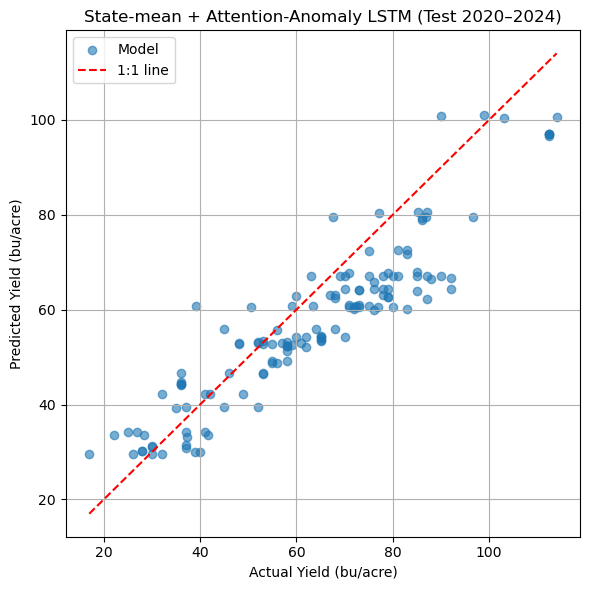

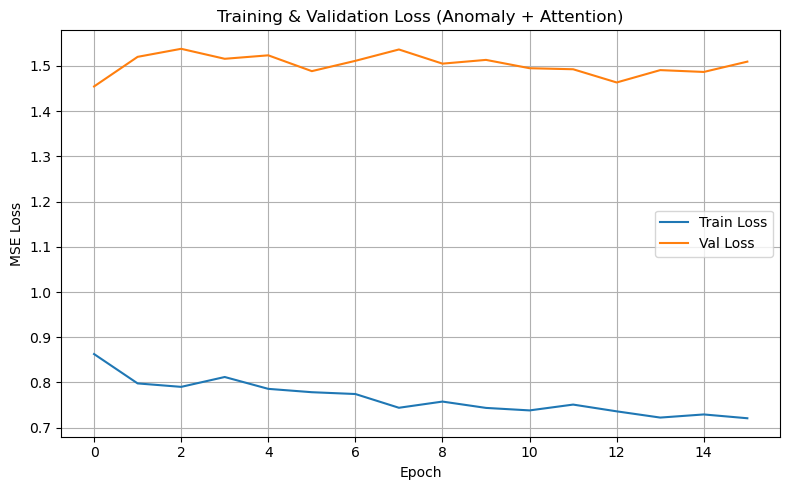

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate, Activation
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

# ================= 1) Read Data & Basic Columns =================
df = pd.read_csv("../data/lstm_input_states_cleaned.csv")
assert {"year","yield","state"}.issubset(df.columns), "Requires year, yield, state columns"
df["year"] = df["year"].astype(int)
target_col = "yield"

static_cols_all = ["ph","ocd","clay","sand","silt","bd","irr_flag","planting_doy","harvest_doy"]
static_cols = [c for c in static_cols_all if c in df.columns]

# Monthly columns: align by month as [ndvi_m, tmax_m, precip_m]
def month_triplet(m):
    mm = f"{m:02d}"
    c1 = [f"ndvi_{mm}", f"tmax_{mm}", f"precip_{mm}"]
    if all(c in df.columns for c in c1): return c1
    c2 = [f"ndvi_{m}", f"tmax_{m}", f"precip_{m}"]
    if all(c in df.columns for c in c2): return c2
    raise ValueError(f"Missing required columns for month {m}")
feat_by_month = [month_triplet(m) for m in range(1,13)]
seq_cols = [c for cols in feat_by_month for c in cols]

df = df.dropna(subset=[target_col]).copy()
df[seq_cols + static_cols] = df[seq_cols + static_cols].fillna(0)

# ================= 2) Year-based Split =================
train_mask = df["year"].between(2000, 2019)
test_mask  = df["year"].between(2020, 2024)
val_mask   = train_mask & df["year"].isin([2017, 2018, 2019])
train_core_mask = train_mask & ~val_mask
if val_mask.sum() == 0:
    yrs = sorted(df.loc[train_mask,"year"].unique())
    k = max(1, int(round(len(yrs)*0.2)))
    val_mask = train_mask & df["year"].isin(yrs[-k:])
    train_core_mask = train_mask & ~val_mask

# ================= 3) Assemble Tensors =================
def make_seq(frame: pd.DataFrame) -> np.ndarray:
    blocks = [frame[cols].values for cols in feat_by_month]  # 12×(N,3)
    return np.stack(blocks, axis=1).astype(np.float32)       # (N,12,3)

def pack(mask):
    sub = df.loc[mask].reset_index(drop=True)
    X_seq = make_seq(sub)
    X_sta = sub[static_cols].values.astype(np.float32) if static_cols else np.zeros((len(sub),0), np.float32)
    y     = sub[target_col].values.astype(np.float32)
    return X_seq, X_sta, y, sub

X_seq_tr, X_sta_tr, y_tr_raw, df_tr = pack(train_core_mask)
X_seq_va, X_sta_va, y_va_raw, df_va = pack(val_mask)
X_seq_te, X_sta_te, y_te_raw, df_te = pack(test_mask)

# ================= 4) Target Decomposition: State Mean + Interannual Anomaly =================
state_mean = df.loc[train_mask].groupby("state")[target_col].mean()
global_mean = df.loc[train_mask, target_col].mean()
def mu_state(s): return s.map(state_mean).fillna(global_mean).values.astype(np.float32)

mu_tr, mu_va, mu_te = mu_state(df_tr["state"]), mu_state(df_va["state"]), mu_state(df_te["state"])
y_tr_anom = y_tr_raw - mu_tr
y_va_anom = y_va_raw - mu_va
# —— Z-score normalization for target anomaly (using training period only for fitting)
anom_scaler = StandardScaler().fit(y_tr_anom.reshape(-1,1))
y_tr_t = anom_scaler.transform(y_tr_anom.reshape(-1,1)).ravel()
y_va_t = anom_scaler.transform(y_va_anom.reshape(-1,1)).ravel()

# ================= 5) Input Standardization (Using Training Statistics Only) =================
# Sequence three channels: channel-wise mean/std across samples and months
C = X_seq_tr.shape[2]
seq_mean = X_seq_tr.reshape(-1, C).mean(axis=0)
seq_std  = X_seq_tr.reshape(-1, C).std(axis=0) + 1e-8
def norm_seq(X): return (X - seq_mean) / seq_std
X_seq_tr, X_seq_va, X_seq_te = map(norm_seq, [X_seq_tr, X_seq_va, X_seq_te])

# Z-score for static features
if X_sta_tr.shape[1] > 0:
    sta_scaler = StandardScaler().fit(X_sta_tr)
    X_sta_tr = sta_scaler.transform(X_sta_tr)
    X_sta_va = sta_scaler.transform(X_sta_va)
    X_sta_te = sta_scaler.transform(X_sta_te)

# ================= 6) Additive Attention Layer =================
class AdditiveAttention(Layer):
    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)
        self.units = units
    def build(self, input_shape):
        self.W = self.add_weight(name="W", shape=(input_shape[-1], self.units),
                                 initializer="glorot_uniform", trainable=True)
        self.v = self.add_weight(name="v", shape=(self.units, 1),
                                 initializer="glorot_uniform", trainable=True)
        super().build(input_shape)
    def call(self, H):  # H: (B, T, D)
        score = tf.tensordot(tf.tanh(tf.tensordot(H, self.W, axes=1)), self.v, axes=1)  # (B,T,1)
        alpha = tf.nn.softmax(score, axis=1)                                             # (B,T,1)
        context = tf.reduce_sum(alpha * H, axis=1)                                       # (B,D)
        return context, tf.squeeze(alpha, axis=-1)                                       # (B,T)

# ================= 7) Build Model: LSTM(96)+Attention, Predict Standardized Anomaly =================
seq_in = Input(shape=(12, X_seq_tr.shape[2]), name="seq_input")
h = LSTM(96, return_sequences=True)(seq_in)
h = Dropout(0.3)(h)
ctx, att = AdditiveAttention(units=32, name="add_att")(h)   # ctx:(B,96)

if X_sta_tr.shape[1] > 0:
    sta_in = Input(shape=(X_sta_tr.shape[1],), name="static_input")
    feat = concatenate([ctx, sta_in])
    inputs = [seq_in, sta_in]
else:
    feat = ctx
    inputs = [seq_in]

feat = Dense(96, activation="relu")(feat)
feat = Dropout(0.3)(feat)
anom_hat_std = Dense(1, name="anom_hat_std")(feat)          # Prediction of standardized anomaly

model = Model(inputs=inputs, outputs=anom_hat_std)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

early = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5, verbose=1)

# Temporal weighting: emphasize recent years
w_tr = 0.5 + 0.5 * (df_tr["year"] - df_tr["year"].min()) / (df_tr["year"].max() - df_tr["year"].min())
w_tr = w_tr.values.astype(np.float32)

history = model.fit(
    {"seq_input": X_seq_tr, "static_input": X_sta_tr} if X_sta_tr.shape[1]>0 else {"seq_input": X_seq_tr},
    y_tr_t,
    sample_weight=w_tr,
    validation_data=(
        ({"seq_input": X_seq_va, "static_input": X_sta_va} if X_sta_va.shape[1]>0 else {"seq_input": X_seq_va}),
        y_va_t
    ),
    epochs=200, batch_size=32, callbacks=[early, plateau], verbose=1
)

# ================= 8) Test Set: Inverse Standardization + Add Back State Mean =================
anom_pred_std = model.predict(
    {"seq_input": X_seq_te, "static_input": X_sta_te} if X_sta_te.shape[1]>0 else {"seq_input": X_seq_te},
    verbose=0
).ravel()
anom_pred = anom_scaler.inverse_transform(anom_pred_std.reshape(-1,1)).ravel()

y_pred = mu_te + anom_pred
y_true = y_te_raw

rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
mae  = float(mean_absolute_error(y_true, y_pred))
r2   = float(r2_score(y_true, y_pred))
print("\n=== Test (2020–2024) — state mean + attention-anomaly LSTM ===")
print(f"RMSE: {rmse:.2f} bu/acre")
print(f"MAE : {mae:.2f} bu/acre")
print(f"R²  : {r2:.3f}")

# ================= 9) Yearly Metrics & Baseline =================
out = pd.DataFrame({"year": df_te["year"].values, "y_true": y_true, "y_pred": y_pred})
def rmse_vec(a,b): return float(np.sqrt(np.mean((a-b)**2)))
year_metrics = (out.groupby("year")
                 .apply(lambda g: pd.Series({
                     "RMSE": rmse_vec(g["y_true"].values, g["y_pred"].values),
                     "MAE" : mean_absolute_error(g["y_true"].values, g["y_pred"].values),
                     "R2"  : r2_score(g["y_true"].values, g["y_pred"].values) if g["y_true"].nunique()>1 else np.nan
                 })))
print("\nPer-year metrics (Test 2020–2024):")
print(year_metrics.round(3))

# Naive baseline (state mean from training period)
base_pred = mu_te
base_rmse = rmse_vec(y_true, base_pred)
base_r2   = r2_score(y_true, base_pred)
print(f"\nNaive baseline (train-state-mean) -> RMSE: {base_rmse:.2f}, R²: {base_r2:.3f}")

# ================= 10) Plots =================
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, label="Model")
mmin, mmax = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
plt.plot([mmin,mmax],[mmin,mmax],'r--',label="1:1 line")
plt.xlabel("Actual Yield (bu/acre)"); plt.ylabel("Predicted Yield (bu/acre)")
plt.title("State-mean + Attention-Anomaly LSTM (Test 2020–2024)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss (Anomaly + Attention)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

# ---- Configuration ----
DATA_PATH = "../data/lstm_input_states_cleaned.csv"
OUT_DIR = "../results/feature_diagnostics"
CORR_TH = 0.90     # Correlation threshold: values above this are considered highly collinear
VIF_TH  = 10.0     # VIF threshold: values above this indicate severe collinearity

os.makedirs(OUT_DIR, exist_ok=True)

def get_cols(df, prefixes):
    cols = []
    for p in prefixes:
        cols += [c for c in df.columns if c.startswith(p)]
    # Remove duplicates while preserving order
    seen = set(); ordered=[]
    for c in cols:
        if c not in seen:
            ordered.append(c); seen.add(c)
    return ordered

def clean_numeric_subset(df, cols):
    sub = df[cols].apply(pd.to_numeric, errors="coerce")
    # Drop columns that are entirely empty or constant
    sub = sub.dropna(axis=1, how="all")
    sub = sub.loc[:, sub.nunique(dropna=True) > 1]
    return sub

def plot_corr(name, corr):
    fig = plt.figure(figsize=(10,8))
    im = plt.imshow(corr, vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks = np.arange(len(corr.columns))
    plt.xticks(ticks, corr.columns, rotation=90)
    plt.yticks(ticks, corr.columns)
    plt.title(f"{name} Monthly Correlation Heatmap")
    plt.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"{name}_corr_heatmap.png"), dpi=200)
    plt.close(fig)

def plot_pca_curve(name, cumexp):
    fig = plt.figure(figsize=(8,5))
    x = np.arange(1, len(cumexp)+1)
    plt.plot(x, cumexp, marker="o")
    plt.axhline(0.95, linestyle="--")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"{name} PCA Explained Variance")
    plt.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"{name}_pca_curve.png"), dpi=200)
    plt.close(fig)

def compute_vif_table(X, cols):
    # statsmodels VIF requires no NaN and purely numerical data
    X = np.asarray(X, dtype=float)
    vifs = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return pd.DataFrame({"feature": cols, "VIF": vifs})

def greedy_drop_high_corr(corr, th=0.90):
    """Greedy backward elimination based on correlation matrix: iteratively remove the column with the highest average correlation until all |r| <= threshold."""
    keep = list(corr.columns)
    C = corr.copy().abs()
    np.fill_diagonal(C.values, 0.0)
    while True:
        max_val = C.values.max()
        if max_val <= th or len(keep) <= 1:
            break
        # Find the column with the highest average correlation and remove it
        avg_corr = C.mean(axis=0)
        drop_col = avg_corr.idxmax()
        keep.remove(drop_col)
        C = C.loc[keep, keep]
        np.fill_diagonal(C.values, 0.0)
    return keep

def analyze_block(df, prefixes, name):
    cols = get_cols(df, prefixes)
    if len(cols) == 0:
        print(f"[{name}] No columns found for prefixes={prefixes}. Skipped.")
        return None

    sub = clean_numeric_subset(df, cols)
    if sub.shape[1] < 2:
        print(f"[{name}] Not enough valid numeric columns after cleaning. Skipped.")
        return None

    # 1) Correlation
    corr = sub.corr()
    plot_corr(name, corr)

    # Find highly correlated pairs
    high_pairs = []
    for i, c1 in enumerate(sub.columns):
        for j, c2 in enumerate(sub.columns):
            if j <= i: continue
            r = corr.loc[c1, c2]
            if abs(r) > CORR_TH:
                high_pairs.append((c1, c2, float(r)))

    # 2) PCA
    scaler = StandardScaler()
    Xs = scaler.fit_transform(sub.values)
    pca = PCA()
    pca.fit(Xs)
    cumexp = np.cumsum(pca.explained_variance_ratio_)
    n95 = int(np.argmax(cumexp >= 0.95) + 1)
    plot_pca_curve(name, cumexp)

    # 3) VIF
    vif_tbl = compute_vif_table(Xs, sub.columns.tolist())
    vif_tbl.to_csv(os.path.join(OUT_DIR, f"{name}_vif.csv"), index=False)

    # 4) Automatic recommendation: retention set based on correlation threshold
    keep_corr = greedy_drop_high_corr(corr, th=CORR_TH)

    # 5) Automatic recommendation: backward elimination based on VIF
    keep_vif = sub.columns.tolist()
    Xv = Xs.copy()
    cols_v = keep_vif.copy()
    # Loop until all VIF <= threshold or too few remain
    while True:
        vif_now = [variance_inflation_factor(Xv, i) for i in range(Xv.shape[1])]
        max_vif = np.max(vif_now)
        if max_vif <= VIF_TH or Xv.shape[1] <= 2:
            break
        drop_idx = int(np.argmax(vif_now))
        drop_col = cols_v[drop_idx]
        # Remove this column
        cols_v.pop(drop_idx)
        Xv = np.delete(Xv, drop_idx, axis=1)
    keep_vif = cols_v

    # Summary output
    summary = {
        "name": name,
        "n_cols": int(sub.shape[1]),
        "high_corr_pairs_count": int(len(high_pairs)),
        "pca_components_95var": int(n95),
        "suggest_keep_by_corr": keep_corr,
        "suggest_keep_by_vif": keep_vif,
    }
    pd.DataFrame(high_pairs, columns=["col1","col2","corr"]).to_csv(
        os.path.join(OUT_DIR, f"{name}_high_corr_pairs.csv"), index=False
    )
    with open(os.path.join(OUT_DIR, f"{name}_summary.txt"), "w") as f:
        f.write(str(summary))

    print(f"\n=== {name} ===")
    print(f"Columns analyzed: {sub.shape[1]}")
    print(f"Pairs with |r| > {CORR_TH}: {len(high_pairs)} (saved to CSV)")
    print(f"PCA components for 95% variance: {n95}")
    print(f"Suggest keep (by corr): {keep_corr}")
    print(f"Suggest keep (by VIF):  {keep_vif}")

    return {
        "corr": corr, "high_pairs": high_pairs, "pca_n95": n95,
        "vif": pd.read_csv(os.path.join(OUT_DIR, f"{name}_vif.csv")),
        "keep_corr": keep_corr, "keep_vif": keep_vif
    }

def main():
    df = pd.read_csv(DATA_PATH)

    blocks = [
        (["ndvi_"], "NDVI"),
        (["tmax_"], "Tmax"),
        (["precip_", "prcp_"], "Precip"),  # Compatible with both prefixes
    ]

    all_results = {}
    for prefixes, name in blocks:
        res = analyze_block(df, prefixes, name)
        all_results[name] = res

    print(f"\nAll diagnostics saved to: {OUT_DIR}")

if __name__ == "__main__":
    main()


=== NDVI ===
Columns analyzed: 12
Pairs with |r| > 0.9: 19 (saved to CSV)
PCA components for 95% variance: 3
Suggest keep (by corr): ['ndvi_02', 'ndvi_07']
Suggest keep (by VIF):  ['ndvi_02', 'ndvi_05', 'ndvi_08', 'ndvi_12']

=== Tmax ===
Columns analyzed: 12
Pairs with |r| > 0.9: 1 (saved to CSV)
PCA components for 95% variance: 6
Suggest keep (by corr): ['tmax_02', 'tmax_05', 'tmax_06', 'tmax_07', 'tmax_08', 'tmax_12']
Suggest keep (by VIF):  ['tmax_02', 'tmax_03', 'tmax_04', 'tmax_05', 'tmax_06', 'tmax_07', 'tmax_08', 'tmax_09', 'tmax_10', 'tmax_11', 'tmax_12']

=== Precip ===
Columns analyzed: 12
Pairs with |r| > 0.9: 0 (saved to CSV)
PCA components for 95% variance: 10
Suggest keep (by corr): ['precip_01', 'precip_02', 'precip_03', 'precip_04', 'precip_05', 'precip_06', 'precip_07', 'precip_08', 'precip_09', 'precip_10', 'precip_11', 'precip_12']
Suggest keep (by VIF):  ['precip_01', 'precip_02', 'precip_03', 'precip_04', 'precip_05', 'precip_06', 'precip_07', 'precip_08', 'preci

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2634 - mae: 0.4323 - val_loss: 0.0322 - val_mae: 0.1442
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0412 - mae: 0.1615 - val_loss: 0.0261 - val_mae: 0.1264
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0399 - mae: 0.1569 - val_loss: 0.0239 - val_mae: 0.1218
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0345 - mae: 0.1463 - val_loss: 0.0222 - val_mae: 0.1171
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0336 - mae: 0.1437 - val_loss: 0.0223 - val_mae: 0.1164
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0343 - mae: 0.1426 - val_loss: 0.0201 - val_mae: 0.1099
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295 - mae: 0.1367 - val_loss: 0.0198 - val_mae: 0.1095
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333 - mae: 0.1441 - val_loss: 0.0183 - val_mae: 0.1051
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.02

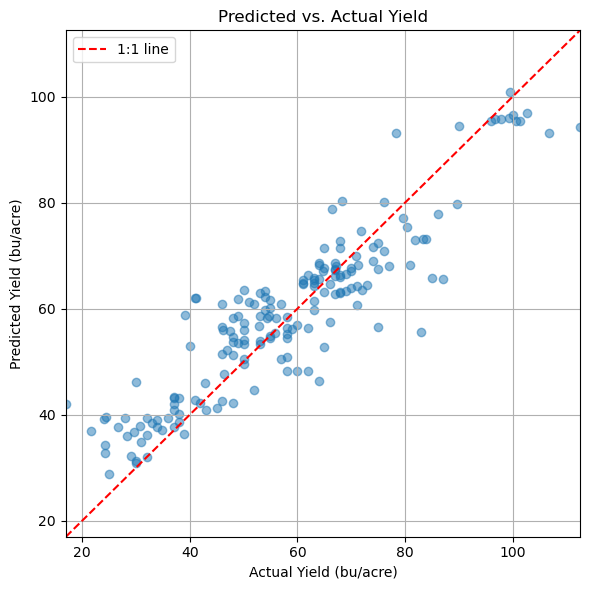

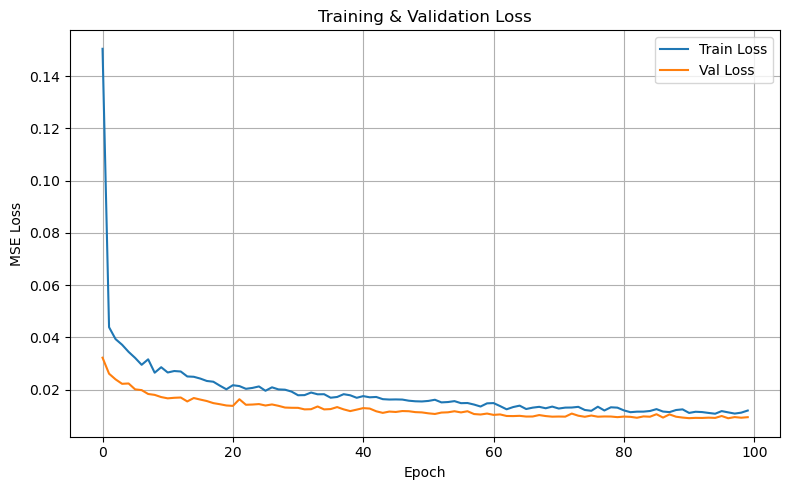

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping

# ===================== Configuration: Months to Keep =====================
KEEP_NDVI_MONTHS  = {2, 5, 8, 12}                       # From your correlation/PCA diagnostics
KEEP_TMAX_MONTHS  = {2, 5, 6, 7, 8, 12}                 # From your diagnostics
KEEP_PRECIP_MONTHS = set(range(1, 13))                  # Keep all precipitation months

# ===================== Read Data =====================
df = pd.read_csv("../data/lstm_input_states_cleaned.csv")

# ===================== Column Name Utilities =====================
def cols_for(prefix):
    return [f"{prefix}_{m:02d}" for m in range(1, 13)]

ndvi_cols   = cols_for("ndvi")
tmax_cols   = cols_for("tmax")
precip_cols = cols_for("precip")

# ===================== Create Masks and "Zero Out" Non-Keep Months =====================
def apply_keep_and_mask(df, prefix, keep_months):
    cols = cols_for(prefix)
    # Mask columns: 1=keep, 0=mask
    mask_cols = [f"{prefix}_mask_{m:02d}" for m in range(1, 13)]
    for m in range(1, 13):
        c = f"{prefix}_{m:02d}"
        keep = 1 if m in keep_months else 0
        df[f"{prefix}_mask_{m:02d}"] = keep
        if keep == 0:
            # Zero out (your features are already scaled to [0,1], zero represents "no information")
            df[c] = 0.0
    return cols + mask_cols  # Return the group's sequence features (original values + masks)

seq_ndvi  = apply_keep_and_mask(df, "ndvi", KEEP_NDVI_MONTHS)
seq_tmax  = apply_keep_and_mask(df, "tmax", KEEP_TMAX_MONTHS)
seq_prec  = apply_keep_and_mask(df, "precip", KEEP_PRECIP_MONTHS)

# Sequence features concatenated in "variable group order + month order" (ensures stable feature arrangement after reshape)
sequence_cols = seq_ndvi + seq_tmax + seq_prec

# Static features
static_cols = ["ph", "ocd", "clay", "sand", "silt", "bd", "irr_flag"]
target_col  = "yield"

# Missing value handling (theoretically no missing after cleaning, but being safe here)
df = df.dropna(subset=[target_col]).copy()
df[sequence_cols + static_cols] = df[sequence_cols + static_cols].fillna(0.0)

# ===================== Yield Normalization =====================
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(df[[target_col]]).ravel()

# ===================== Organize LSTM Input Tensor =====================
# Our sequence_cols represent 12 months, each month's "feature vector" consists of:
#   NDVI(1) + NDVI_mask(1) + Tmax(1) + Tmax_mask(1) + Precip(1) + Precip_mask(1)
# This arrangement ensures consistent feature dimensions at each time step.
# Below we rearrange sequence_cols into monthly interleaved order: [all variables for month1..., all variables for month2..., ... month12...]
def interleave_by_month(ndvi_cols, tmax_cols, precip_cols):
    out = []
    for m in range(1, 13):
        out.extend([f"ndvi_{m:02d}", f"ndvi_mask_{m:02d}"])
        out.extend([f"tmax_{m:02d}", f"tmax_mask_{m:02d}"])
        out.extend([f"precip_{m:02d}", f"precip_mask_{m:02d}"])
    return out

sequence_cols_by_month = interleave_by_month(ndvi_cols, tmax_cols, precip_cols)

X_seq_mat = df[sequence_cols_by_month].values
# Number of features per time step: 3 variables * 2 (value + mask) = 6
n_features_per_timestep = 6
X_seq = X_seq_mat.reshape(-1, 12, n_features_per_timestep)

X_static = df[static_cols].values
y = y_scaled

# ===================== Train/Test Split =====================
X_seq_tr, X_seq_te, X_sta_tr, X_sta_te, y_tr, y_te = train_test_split(
    X_seq, X_static, y, test_size=0.2, random_state=42
)

# ===================== Build Model (consistent with your current setup) =====================
seq_input = Input(shape=(12, n_features_per_timestep), name="seq_input")
lstm_out  = LSTM(64)(seq_input)
drop_seq  = Dropout(0.2)(lstm_out)

sta_input = Input(shape=(X_static.shape[1],), name="static_input")
merged    = concatenate([drop_seq, sta_input])
dense1    = Dense(64, activation="relu")(merged)
drop_comb = Dropout(0.2)(dense1)
output    = Dense(1)(drop_comb)

model = Model(inputs=[seq_input, sta_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = model.fit(
    {"seq_input": X_seq_tr, "static_input": X_sta_tr},
    y_tr,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ===================== Prediction & Inverse Normalization =====================
y_pred_scaled = model.predict({"seq_input": X_seq_te, "static_input": X_sta_te})
y_te_actual   = y_scaler.inverse_transform(y_te.reshape(-1, 1)).ravel()
y_pred_actual = y_scaler.inverse_transform(y_pred_scaled).ravel()

rmse = np.sqrt(mean_squared_error(y_te_actual, y_pred_actual))
mae  = mean_absolute_error(y_te_actual, y_pred_actual)
r2   = r2_score(y_te_actual, y_pred_actual)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE:  {mae:.2f}")
print(f"Test R²:   {r2:.3f}")

# ===================== Visualization =====================
plt.figure(figsize=(6,6))
plt.scatter(y_te_actual, y_pred_actual, alpha=0.5)
lims = [min(y_te_actual.min(), y_pred_actual.min()), max(y_te_actual.max(), y_pred_actual.max())]
plt.plot(lims, lims, 'r--', label='1:1 line')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual Yield (bu/acre)"); plt.ylabel("Predicted Yield (bu/acre)")
plt.title("Predicted vs. Actual Yield")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.title("Training & Validation Loss")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

In [ ]:
# -*- coding: utf-8 -*-
# filename: keep_months_experiments_results.py
# Purpose: Generate keep_months_experiments_results.csv with columns:
# Seed, Split, TestYears, Calibrated(True/False), Exp, NDVI, Tmax, Precip, RMSE, MAE, R2, a, b

import itertools, os, random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# ----------------------------- paths & config -----------------------------
DATA_PATH  = "../data/lstm_input_states_cleaned.csv"
OUTPUT_CSV = "../results/keep_months_experiments_results.csv"

# Multiple random seeds (can be modified)
SEEDS = [0, 1, 2, 3, 4]

os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)

def set_all_seeds(seed: int):
    random.seed(seed); np.random.seed(seed); tf.keras.utils.set_random_seed(seed)

# ----------------------------- helpers -----------------------------
def detect_precip_prefix(df):
    if any(c.startswith("precip_") for c in df.columns): return "precip"
    if any(c.startswith("prcp_")   for c in df.columns): return "prcp"
    return None

def cols_for(prefix, df):
    cols = []
    for m in range(1, 13):
        mm = f"{m:02d}"
        c1, c2 = f"{prefix}_{mm}", f"{prefix}_{m}"
        if c1 in df.columns: cols.append(c1)
        elif c2 in df.columns: cols.append(c2)
        else: raise ValueError(f"Missing column: {prefix}_{mm} (or {prefix}_{m})")
    return cols

def apply_keep_and_mask(df, prefix, keep_months):
    cols = cols_for(prefix, df)
    for m in range(1, 13):
        mm = f"{m:02d}"
        val_col  = f"{prefix}_{mm}" if f"{prefix}_{mm}" in df.columns else f"{prefix}_{m}"
        mask_col = f"{prefix}_mask_{mm}"
        keep = 1 if m in keep_months else 0
        df[mask_col] = keep
        if keep == 0: df[val_col] = 0.0
    return cols + [f"{prefix}_mask_{m:02d}" for m in range(1, 13)]

def build_sequence_matrix(df, precip_prefix):
    out_cols = []
    for m in range(1, 13):
        mm = f"{m:02d}"
        ndvi_v = f"ndvi_{mm}" if f"ndvi_{mm}" in df.columns else f"ndvi_{m}"
        tmax_v = f"tmax_{mm}" if f"tmax_{mm}" in df.columns else f"tmax_{m}"
        prcp_v = f"{precip_prefix}_{mm}" if f"{precip_prefix}_{mm}" in df.columns else f"{precip_prefix}_{m}"
        out_cols += [ndvi_v, f"ndvi_mask_{mm}", tmax_v, f"tmax_mask_{mm}", prcp_v, f"{precip_prefix}_mask_{mm}"]
    X = df[out_cols].values
    return X.reshape(-1, 12, 6)  # 12 steps × (3 vars × value/mask)

def make_model(n_static):
    seq_input = Input(shape=(12, 6), name="seq_input")
    lstm_out  = LSTM(64)(seq_input)
    drop_seq  = Dropout(0.2)(lstm_out)
    sta_input = Input(shape=(n_static,), name="static_input")
    merged    = concatenate([drop_seq, sta_input])
    dense1    = Dense(64, activation="relu")(merged)
    drop2     = Dropout(0.2)(dense1)
    output    = Dense(1)(drop2)
    model = Model(inputs=[seq_input, sta_input], outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

def metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    return rmse, mae, r2

def train_and_eval(df, keep_ndvi, keep_tmax, keep_precip,
                   tr_idx, va_idx, te_idx, precip_prefix, seed, verbose=0):
    """Returns: both uncalibrated and calibrated metrics + calibration coefficients a,b (fitted on validation set)"""
    df = df.copy()
    _ = apply_keep_and_mask(df, "ndvi", keep_ndvi)
    _ = apply_keep_and_mask(df, "tmax", keep_tmax)
    _ = apply_keep_and_mask(df, precip_prefix, keep_precip)

    static_cols = [c for c in ["ph","ocd","clay","sand","silt","bd","irr_flag","planting_doy","harvest_doy"] if c in df.columns]
    target_col  = "yield"
    df = df.dropna(subset=[target_col])
    df[static_cols] = df[static_cols].fillna(0.0)

    X_seq = build_sequence_matrix(df, precip_prefix)
    X_sta = df[static_cols].values
    y_all = df[target_col].values

    y_scaler = MinMaxScaler().fit(y_all[tr_idx].reshape(-1,1))
    y_scaled = y_scaler.transform(y_all.reshape(-1,1)).ravel()

    X_seq_tr, X_seq_va, X_seq_te = X_seq[tr_idx], X_seq[va_idx], X_seq[te_idx]
    X_sta_tr, X_sta_va, X_sta_te = X_sta[tr_idx], X_sta[va_idx], X_sta[te_idx]
    y_tr,     y_va,     y_te     = y_scaled[tr_idx], y_scaled[va_idx], y_scaled[te_idx]

    set_all_seeds(seed)
    model = make_model(n_static=X_sta.shape[1])
    cb = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit({"seq_input": X_seq_tr, "static_input": X_sta_tr}, y_tr,
              validation_data=({"seq_input": X_seq_va, "static_input": X_sta_va}, y_va),
              epochs=100, batch_size=32, callbacks=[cb], verbose=verbose)

    pred_va_s = model.predict({"seq_input": X_seq_va, "static_input": X_sta_va}, verbose=0).ravel()
    pred_te_s = model.predict({"seq_input": X_seq_te, "static_input": X_sta_te}, verbose=0).ravel()

    y_va_act = y_scaler.inverse_transform(y_va.reshape(-1,1)).ravel()
    y_te_act = y_scaler.inverse_transform(y_te.reshape(-1,1)).ravel()
    y_va_hat = y_scaler.inverse_transform(pred_va_s.reshape(-1,1)).ravel()
    y_te_hat = y_scaler.inverse_transform(pred_te_s.reshape(-1,1)).ravel()

    rmse_u, mae_u, r2_u = metrics(y_te_act, y_te_hat)

    # Linear calibration (fitted on validation set), applied to test set
    a, b = (1.0, 0.0)
    if np.std(y_va_hat) > 1e-8: a, b = np.polyfit(y_va_hat, y_va_act, 1)
    y_te_hat_cal = a * y_te_hat + b
    rmse_c, mae_c, r2_c = metrics(y_te_act, y_te_hat_cal)

    return {"uncal": {"RMSE": rmse_u, "MAE": mae_u, "R2": r2_u},
            "cal":   {"RMSE": rmse_c, "MAE": mae_c, "R2": r2_c, "a": float(a), "b": float(b)}}

# ----------------------------- main -----------------------------
def main():
    df = pd.read_csv(DATA_PATH)
    if "year" not in df.columns: raise ValueError("Data missing 'year' column.")
    df["year"] = df["year"].astype(int)

    # Temporal split: Train=2000–2016, Val=2017–2019, Test=2020–2024 (automatically truncated based on data)
    train_mask = df["year"].between(2000, 2019)
    val_mask   = df["year"].isin([2017, 2018, 2019])
    train_core = train_mask & ~val_mask
    test_mask  = df["year"].between(2020, 2024)

    tr_idx = df.index[train_core].to_numpy()
    va_idx = df.index[val_mask].to_numpy()
    te_idx = df.index[test_mask].to_numpy()

    val_years  = sorted(df.loc[val_mask,  "year"].unique().tolist())
    test_years = sorted(df.loc[test_mask, "year"].unique().tolist())
    test_years_str = f"{test_years[0]}–{test_years[-1]}" if len(test_years) else "NA"
    SPLIT_TAG = f"temporal_2000-2016|2017-2019|{test_years_str}"

    precip_prefix = detect_precip_prefix(df)
    if precip_prefix is None: raise ValueError("Precipitation columns not found (precip_/prcp_).")
    print(f"Using precip prefix: {precip_prefix}_")
    print(f"Valid years: {val_years} | Test years: {test_years_str}")

    all12 = set(range(1,13))
    ndvi_sets = [("NDVI-all12", all12), ("NDVI-2,5,8,12", {2,5,8,12}), ("NDVI-2,7,12", {2,7,12})]
    tmax_sets = [("Tmax-all12", all12), ("Tmax-2,5,6,7,8,12", {2,5,6,7,8,12}), ("Tmax-2,6,8,12", {2,6,8,12})]
    precip_sets = [(f"{precip_prefix.title()}-all12", all12), (f"{precip_prefix.title()}-1,4,7,10", {1,4,7,10})]

    rows = []
    total = len(ndvi_sets)*len(tmax_sets)*len(precip_sets)
    print(f"\nRunning {total} combinations × {len(SEEDS)} seeds...\n")

    baseline = ("NDVI-all12", all12), ("Tmax-all12", all12), (f"{precip_prefix.title()}-all12", all12)

    # Baseline
    for seed in SEEDS:
        resb = train_and_eval(df, baseline[0][1], baseline[1][1], baseline[2][1],
                              tr_idx, va_idx, te_idx, precip_prefix, seed=seed, verbose=0)
        for cal in [False, True]:
            met = resb["cal" if cal else "uncal"]
            rows.append({
                "Seed": seed, "Split": SPLIT_TAG, "TestYears": test_years_str, "Calibrated": cal,
                "Exp": "BASELINE", "NDVI": baseline[0][0], "Tmax": baseline[1][0], "Precip": baseline[2][0],
                "RMSE": met["RMSE"], "MAE": met["MAE"], "R2": met["R2"], "a": met.get("a"), "b": met.get("b")
            })

    # Other combinations
    exp_total, exp_id = total-1, 0
    for (ndvi_name, ndvi_keep), (tmax_name, tmax_keep), (precip_name, precip_keep) in itertools.product(ndvi_sets, tmax_sets, precip_sets):
        if ndvi_name=="NDVI-all12" and tmax_name=="Tmax-all12" and precip_name.endswith("all12"): continue
        exp_id += 1; combo_name = f"{ndvi_name} | {tmax_name} | {precip_name}"
        print(f"[{exp_id}/{exp_total}] {combo_name}")
        for seed in SEEDS:
            resv = train_and_eval(df, ndvi_keep, tmax_keep, precip_keep,
                                  tr_idx, va_idx, te_idx, precip_prefix, seed=seed, verbose=0)
            for cal in [False, True]:
                met = resv["cal" if cal else "uncal"]
                rows.append({
                    "Seed": seed, "Split": SPLIT_TAG, "TestYears": test_years_str, "Calibrated": cal,
                    "Exp": combo_name, "NDVI": ndvi_name, "Tmax": tmax_name, "Precip": precip_name,
                    "RMSE": met["RMSE"], "MAE": met["MAE"], "R2": met["R2"], "a": met.get("a"), "b": met.get("b")
                })

    res = pd.DataFrame(rows)
    res.to_csv(OUTPUT_CSV, index=False)
    print(f"\nSaved results to: {OUTPUT_CSV}")
    print("Columns:", list(res.columns))

if __name__ == "__main__":
    main()

Using precip prefix: precip_
Valid years: [2017, 2018, 2019] | Test years: 2020–2023

Running 18 combinations × 5 seeds...

[1/17] NDVI-all12 | Tmax-all12 | Precip-1,4,7,10
[2/17] NDVI-all12 | Tmax-2,5,6,7,8,12 | Precip-all12
[3/17] NDVI-all12 | Tmax-2,5,6,7,8,12 | Precip-1,4,7,10
[4/17] NDVI-all12 | Tmax-2,6,8,12 | Precip-all12
[5/17] NDVI-all12 | Tmax-2,6,8,12 | Precip-1,4,7,10
[6/17] NDVI-2,5,8,12 | Tmax-all12 | Precip-all12
[7/17] NDVI-2,5,8,12 | Tmax-all12 | Precip-1,4,7,10
[8/17] NDVI-2,5,8,12 | Tmax-2,5,6,7,8,12 | Precip-all12
[9/17] NDVI-2,5,8,12 | Tmax-2,5,6,7,8,12 | Precip-1,4,7,10
[10/17] NDVI-2,5,8,12 | Tmax-2,6,8,12 | Precip-all12
[11/17] NDVI-2,5,8,12 | Tmax-2,6,8,12 | Precip-1,4,7,10
[12/17] NDVI-2,7,12 | Tmax-all12 | Precip-all12
[13/17] NDVI-2,7,12 | Tmax-all12 | Precip-1,4,7,10
[14/17] NDVI-2,7,12 | Tmax-2,5,6,7,8,12 | Precip-all12
[15/17] NDVI-2,7,12 | Tmax-2,5,6,7,8,12 | Precip-1,4,7,10
[16/17] NDVI-2,7,12 | Tmax-2,6,8,12 | Precip-all12
[17/17] NDVI-2,7,12 | Tmax-2,

In [ ]:
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---- Config ----
DATA_PATH = "../data/lstm_input_states_cleaned.csv"
OUT_DIR   = "../results/feature_diagnostics"
CORR_TH   = 0.90   # Features with |r| > this threshold are considered highly collinear
VIF_TH    = 10.0   # Features with VIF > this threshold are considered severely collinear
TRAIN_YEARS = (2000, 2019)  # Perform diagnostics only on the training period

os.makedirs(OUT_DIR, exist_ok=True)

def month_col(var, m, df_cols):
    mm = f"{m:02d}"
    c1 = f"{var}_{mm}"
    if c1 in df_cols: return c1
    c2 = f"{var}_{m}"
    if c2 in df_cols: return c2
    return None

def get_cols(df, prefixes):
    cols = []
    for p in prefixes:
        # Get columns in monthly order to ensure 01..12 sequence
        for m in range(1, 13):
            c = month_col(p.rstrip("_"), m, df.columns) if p in ["ndvi_", "tmax_", "precip_", "prcp_"] else None
            if c is not None and c.startswith(p.rstrip("_")):
                cols.append(c)
        # Fallback: append all columns starting with p (in their original order)
        if not cols:
            cols += [c for c in df.columns if c.startswith(p)]
    # Remove duplicates while preserving order
    seen=set(); ordered=[]
    for c in cols:
        if c not in seen: ordered.append(c); seen.add(c)
    return ordered

def clean_numeric_subset(df, cols):
    sub = df[cols].apply(pd.to_numeric, errors="coerce")
    # Remove all-null columns and constant columns
    sub = sub.dropna(axis=1, how="all")
    sub = sub.loc[:, sub.nunique(dropna=True) > 1]
    # Drop rows with excessive missing values (optional: 20% threshold)
    sub = sub.dropna(axis=0, thresh=int(0.8*sub.shape[1])).fillna(sub.mean())
    return sub

def plot_corr(name, corr):
    fig = plt.figure(figsize=(10,8))
    im = plt.imshow(corr.values, vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks = np.arange(len(corr.columns))
    plt.xticks(ticks, corr.columns, rotation=90)
    plt.yticks(ticks, corr.columns)
    plt.title(f"{name} Monthly Correlation Heatmap (Train {TRAIN_YEARS[0]}–{TRAIN_YEARS[1]})")
    plt.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"{name}_corr_heatmap.png"), dpi=200)
    plt.close(fig)

def plot_pca_curve(name, cumexp):
    fig = plt.figure(figsize=(8,5))
    x = np.arange(1, len(cumexp)+1)
    plt.plot(x, cumexp, marker="o")
    plt.axhline(0.95, linestyle="--", label="95%")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"{name} PCA Explained Variance (Train {TRAIN_YEARS[0]}–{TRAIN_YEARS[1]})")
    plt.legend()
    plt.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"{name}_pca_curve.png"), dpi=200)
    plt.close(fig)

def compute_vif_table(X, cols):
    X = np.asarray(X, dtype=float)
    vifs = []
    for i in range(X.shape[1]):
        try:
            v = variance_inflation_factor(X, i)
        except Exception:
            v = np.inf
        vifs.append(float(v))
    return pd.DataFrame({"feature": cols, "VIF": vifs})

def greedy_drop_high_corr(corr, th=0.90):
    """Greedy backward elimination based on correlation matrix: iteratively removes the column with the highest average correlation until all |r| <= threshold."""
    keep = list(corr.columns)
    C = corr.copy().abs()
    np.fill_diagonal(C.values, 0.0)
    while True:
        if len(keep) <= 1: break
        max_val = C.values.max()
        if max_val <= th: break
        avg_corr = C.mean(axis=0)
        drop_col = avg_corr.idxmax()
        keep.remove(drop_col)
        C = C.loc[keep, keep]
        np.fill_diagonal(C.values, 0.0)
    return keep

def analyze_block(df_train, prefixes, name):
    cols = get_cols(df_train, prefixes)
    if len(cols) == 0:
        print(f"[{name}] No columns found for prefixes={prefixes}. Skipped.")
        return None

    sub = clean_numeric_subset(df_train, cols)
    if sub.shape[1] < 2:
        print(f"[{name}] Not enough valid numeric columns after cleaning. Skipped.")
        return None

    # 1) Correlation analysis
    corr = sub.corr()
    corr.to_csv(os.path.join(OUT_DIR, f"{name}_corr_matrix.csv"))
    plot_corr(name, corr)

    # Identify highly correlated pairs
    high_pairs = []
    for i, c1 in enumerate(sub.columns):
        for j, c2 in enumerate(sub.columns):
            if j <= i: continue
            r = corr.loc[c1, c2]
            if abs(r) > CORR_TH:
                high_pairs.append((c1, c2, float(r)))

    # 2) PCA (after standardization)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(sub.values)
    pca = PCA()
    pca.fit(Xs)
    cumexp = np.cumsum(pca.explained_variance_ratio_)
    n95 = int(np.argmax(cumexp >= 0.95) + 1)
    plot_pca_curve(name, cumexp)

    # 3) VIF calculation
    vif_tbl = compute_vif_table(Xs, sub.columns.tolist())
    vif_path = os.path.join(OUT_DIR, f"{name}_vif.csv")
    vif_tbl.to_csv(vif_path, index=False)

    # 4) Feature retention based on correlation threshold
    keep_corr = greedy_drop_high_corr(corr, th=CORR_TH)

    # 5) Backward elimination based on VIF
    keep_vif = sub.columns.tolist()
    Xv = Xs.copy()
    cols_v = keep_vif.copy()
    while Xv.shape[1] > 2:
        vif_now = []
        for i in range(Xv.shape[1]):
            try:
                v = variance_inflation_factor(Xv, i)
            except Exception:
                v = np.inf
            vif_now.append(float(v))
        max_vif = np.max(vif_now)
        if not np.isfinite(max_vif) or max_vif > VIF_TH:
            drop_idx = int(np.argmax(vif_now))
            cols_v.pop(drop_idx)
            Xv = np.delete(Xv, drop_idx, axis=1)
        else:
            break
    keep_vif = cols_v

    # Compile summary output
    summary = {
        "name": name,
        "n_cols": int(sub.shape[1]),
        "high_corr_pairs_count": int(len(high_pairs)),
        "pca_components_95var": int(n95),
        "suggest_keep_by_corr": keep_corr,
        "suggest_keep_by_vif": keep_vif,
        "corr_csv": os.path.join(OUT_DIR, f"{name}_corr_matrix.csv"),
        "vif_csv": vif_path
    }
    pd.DataFrame(high_pairs, columns=["col1","col2","corr"]).to_csv(
        os.path.join(OUT_DIR, f"{name}_high_corr_pairs.csv"), index=False
    )
    with open(os.path.join(OUT_DIR, f"{name}_summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    print(f"\n=== {name} (Train {TRAIN_YEARS[0]}–{TRAIN_YEARS[1]}) ===")
    print(f"Columns analyzed: {sub.shape[1]}")
    print(f"Pairs with |r| > {CORR_TH}: {len(high_pairs)} (saved)")
    print(f"PCA components for 95% variance: {n95}")
    print(f"Suggest keep (by corr): {keep_corr}")
    print(f"Suggest keep (by VIF):  {keep_vif}")

    return {
        "corr": corr, "high_pairs": high_pairs, "pca_n95": n95,
        "vif": vif_tbl, "keep_corr": keep_corr, "keep_vif": keep_vif
    }

def main():
    df = pd.read_csv(DATA_PATH)
    if "year" not in df.columns:
        raise ValueError("Data missing 'year' column, cannot filter by training period.")
    df["year"] = df["year"].astype(int)

    # Use only training period for diagnostics to avoid seeing test year distributions
    df_train = df[(df["year"] >= TRAIN_YEARS[0]) & (df["year"] <= TRAIN_YEARS[1])].copy()

    blocks = [
        (["ndvi_"],   "NDVI"),
        (["tmax_"],   "Tmax"),
        (["precip_", "prcp_"], "Precip")  # Compatible with both prefixes
    ]

    all_results = {}
    for prefixes, name in blocks:
        res = analyze_block(df_train, prefixes, name)
        all_results[name] = res

    # Compile all "suggested keep lists" into a master JSON for easy access in subsequent modeling
    keep_dict = {
        k: {
            "keep_by_corr": (res["keep_corr"] if res else []),
            "keep_by_vif":  (res["keep_vif"]  if res else [])
        } for k, res in all_results.items()
    }
    with open(os.path.join(OUT_DIR, "keep_suggestions_all.json"), "w", encoding="utf-8") as f:
        json.dump(keep_dict, f, ensure_ascii=False, indent=2)

    print(f"\nAll diagnostics saved to: {OUT_DIR}")

if __name__ == "__main__":
    main()


=== NDVI (Train 2000–2019) ===
Columns analyzed: 12
Pairs with |r| > 0.9: 19 (saved)
PCA components for 95% variance: 3
Suggest keep (by corr): ['ndvi_02', 'ndvi_07']
Suggest keep (by VIF):  ['ndvi_02', 'ndvi_05', 'ndvi_08', 'ndvi_11', 'ndvi_12']

=== Tmax (Train 2000–2019) ===
Columns analyzed: 12
Pairs with |r| > 0.9: 1 (saved)
PCA components for 95% variance: 7
Suggest keep (by corr): ['tmax_01', 'tmax_02', 'tmax_03', 'tmax_05', 'tmax_06', 'tmax_07', 'tmax_08', 'tmax_09', 'tmax_10', 'tmax_11', 'tmax_12']
Suggest keep (by VIF):  ['tmax_01', 'tmax_02', 'tmax_03', 'tmax_04', 'tmax_05', 'tmax_06', 'tmax_07', 'tmax_08', 'tmax_09', 'tmax_10', 'tmax_11', 'tmax_12']

=== Precip (Train 2000–2019) ===
Columns analyzed: 12
Pairs with |r| > 0.9: 0 (saved)
PCA components for 95% variance: 10
Suggest keep (by corr): ['precip_01', 'precip_02', 'precip_03', 'precip_04', 'precip_05', 'precip_06', 'precip_07', 'precip_08', 'precip_09', 'precip_10', 'precip_11', 'precip_12']
Suggest keep (by VIF):  [

In [ ]:
# make_keep_months_plots.py  (fixed color selection)
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------- Paths -------------------------
IN_PATH = "../results/keep_months_experiments_results.csv"
OUT_DIR = Path("../results/keep_months_plots")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------- Color Scheme (Morandi) -------------------------
BLUE = (157/255, 195/255, 231/255)   # R157 G195 B231 (improved)
PINK = (213/255, 143/255, 177/255)   # R213 G143 B177 (worse)
NEU  = (0.78, 0.78, 0.78)            # neutral for exactly 0
TXT  = "#333333"
GRID = "#ADADAD"

plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.edgecolor": "#BBBBBB",
    "axes.linewidth": 0.8,
    "axes.grid": True,
    "grid.color": GRID,
    "grid.alpha": 0.25,
    "grid.linewidth": 0.8,
})

# ------------------------- Read & Validate -------------------------
df = pd.read_csv(IN_PATH)
if "Exp" not in df.columns:
    raise ValueError("Result file missing 'Exp' column.")

for m in ["RMSE", "MAE", "R2"]:
    if m not in df.columns:
        raise ValueError(f"Result file missing {m} column.")

if "BASELINE" not in df["Exp"].values:
    raise ValueError("BASELINE row not found in result file.")

# Compatible with Precip/Prcp column names
if "Precip" in df.columns:
    PRECIP_COL = "Precip"
elif "Prcp" in df.columns:
    PRECIP_COL = "Prcp"
else:
    raise ValueError("Precip/Prcp column not found.")

# ------------------------- Calculate Δ Metrics -------------------------
base = df[df["Exp"] == "BASELINE"].iloc[0]
df["ΔRMSE"] = df["RMSE"] - base["RMSE"]
df["ΔMAE"]  = df["MAE"]  - base["MAE"]
df["ΔR2"]   = df["R2"]   - base["R2"]

# Exclude baseline
plot_df = df[df["Exp"] != "BASELINE"].copy()

# ------------------------- Utilities -------------------------
def _pretty_ylabels(row: pd.Series) -> str:
    if all(c in row.index for c in ["NDVI", "Tmax", PRECIP_COL]):
        return f"{row['NDVI']} · {row['Tmax']} · {row[PRECIP_COL]}"
    return str(row["Exp"])

def _nonsymmetric_xlim(vals: np.ndarray, pad=0.08):
    lo, hi = float(np.min(vals)), float(np.max(vals))
    span = hi - lo
    if span <= 0:
        span = max(abs(lo), abs(hi), 1.0)
    lo -= pad * span
    hi += pad * span
    return lo, hi

def _make_colors(vals: np.ndarray, reverse: bool) -> list:
    """
    Return colors for each value:
      reverse=True   -> Error metrics (ΔRMSE/ΔMAE), <0 indicates improvement->blue; >0 indicates deterioration->pink; =0 neutral gray
      reverse=False  -> R² metric, >0 indicates improvement->blue; <0 indicates deterioration->pink; =0 neutral gray
    """
    cols = []
    for v in vals:
        if reverse:
            cols.append(BLUE if v < 0 else (PINK if v > 0 else NEU))
        else:
            cols.append(BLUE if v > 0 else (PINK if v < 0 else NEU))
    return cols

def plot_delta_bar(d: pd.DataFrame,
                   metric_col: str,
                   title: str,
                   x_label: str,
                   filename: str,
                   reverse: bool = False,
                   symmetric: bool = True,
                   sym_quantile: float | None = 0.98):
    """
    reverse=False: Higher values are better (ΔR²); reverse=True: Lower values are better (ΔRMSE/ΔMAE)
    symmetric=True: Display symmetrically centered at 0; sym_quantile can crop extreme values to reduce whitespace.
    """
    d = d.copy()
    d["label"] = d.apply(_pretty_ylabels, axis=1)
    d = d.sort_values(metric_col, ascending=True if reverse else False)

    vals = d[metric_col].values.astype(float)
    colors = _make_colors(vals, reverse=reverse)  # <- Fixed: returns list of RGB tuples

    # Symmetric x-axis to center 0
    if symmetric:
        if sym_quantile is None:
            max_abs = max(1e-8, float(np.max(np.abs(vals))))
        else:
            max_abs = max(1e-8, float(np.quantile(np.abs(vals), sym_quantile)))
        xlim = (-1.08 * max_abs, 1.08 * max_abs)
    else:
        xlim = _nonsymmetric_xlim(vals)

    # Create plot
    h = max(4.5, len(d) * 0.26)
    fig, ax = plt.subplots(figsize=(11, h))
    y = np.arange(len(d))
    bars = ax.barh(y, vals, color=colors, edgecolor="none", height=0.72)

    ax.set_yticks(y)
    ax.set_yticklabels(d["label"].values, color=TXT)
    ax.set_xlabel(x_label); ax.set_ylabel("Month selection (NDVI · Tmax · Precip)")
    ax.set_title(title, pad=12)
    ax.axvline(0, color="#666666", lw=0.9, ls="--")
    ax.grid(axis="x", alpha=0.25)
    ax.set_xlim(*xlim)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fmt = "{:+.3f}" if metric_col == "ΔR2" else "{:+.2f}"
    for yi, (v, b) in enumerate(zip(vals, bars)):
        ax.annotate(fmt.format(v), xy=(v, yi),
                    xytext=(6 if v >= 0 else -6, 0),
                    textcoords="offset points", va="center",
                    ha="left" if v >= 0 else "right", color=TXT)

    plt.tight_layout()
    plt.subplots_adjust(left=0.32, right=0.97, top=0.90, bottom=0.14)
    fig.savefig(OUT_DIR / filename, dpi=300, bbox_inches="tight", pad_inches=0.25)
    plt.close(fig)

# ------------------------- Three Overview Plots (0-centered) -------------------------
plot_delta_bar(
    plot_df, "ΔR2",
    "ΔR² vs baseline (higher is better)",
    "ΔR² (absolute units)",
    "delta_R2_all.png",
    reverse=False, symmetric=True, sym_quantile=0.98
)

plot_delta_bar(
    plot_df, "ΔRMSE",
    "ΔRMSE vs baseline (lower is better)",
    r"ΔRMSE (bu acre$^{-1}$)",
    "delta_RMSE_all.png",
    reverse=True, symmetric=True, sym_quantile=0.98
)

plot_delta_bar(
    plot_df, "ΔMAE",
    "ΔMAE vs baseline (lower is better)",
    r"ΔMAE (bu acre$^{-1}$)",
    "delta_MAE_all.png",
    reverse=True, symmetric=True, sym_quantile=0.98
)

# ------------------------- Marginal Ablation (single variable change) -------------------------
def filter_marginal(df_all: pd.DataFrame, which: str) -> pd.DataFrame:
    if which == "NDVI":
        return df_all[(df_all["Tmax"] == "Tmax-all12")
                      & (df_all[PRECIP_COL].str.endswith("all12"))
                      & (df_all["NDVI"] != "NDVI-all12")]
    if which == "Tmax":
        return df_all[(df_all["NDVI"] == "NDVI-all12")
                      & (df_all[PRECIP_COL].str.endswith("all12"))
                      & (df_all["Tmax"] != "Tmax-all12")]
    if which == PRECIP_COL:
        return df_all[(df_all["NDVI"] == "NDVI-all12")
                      & (df_all["Tmax"] == "Tmax-all12")
                      & (~df_all[PRECIP_COL].str.endswith("all12"))]
    raise ValueError("which must be NDVI / Tmax / Precip(Prcp)")

for var in ["NDVI", "Tmax", PRECIP_COL]:
    sub = filter_marginal(plot_df, var)
    if len(sub) == 0:
        continue
    plot_delta_bar(
        sub, "ΔR2", f"[{var}-only] ΔR² vs baseline", "ΔR²",
        f"delta_R2_{var}_only.png",
        reverse=False, symmetric=True, sym_quantile=0.98
    )
    plot_delta_bar(
        sub, "ΔRMSE", f"[{var}-only] ΔRMSE vs baseline", r"ΔRMSE (bu acre$^{-1}$)",
        f"delta_RMSE_{var}_only.png",
        reverse=True, symmetric=True, sym_quantile=0.98
    )

# ------------------------- ΔR² vs ΔRMSE Scatter Plot -------------------------
fig, ax = plt.subplots(figsize=(7.2, 6.2))
ax.scatter(plot_df["ΔR2"], plot_df["ΔRMSE"], s=36, c="#7F7F7F", alpha=0.75, edgecolor="none")
ax.axvline(0, color="#666666", lw=0.9, ls="--")
ax.axhline(0, color="#666666", lw=0.9, ls="--")
ax.set_xlabel("ΔR² (higher better)")
ax.set_ylabel(r"ΔRMSE (lower better, bu acre$^{-1}$)")
ax.set_title("Trade-off: ΔR² vs ΔRMSE (vs baseline)", pad=10)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout()
fig.savefig(OUT_DIR / "delta_scatter.png", dpi=300, bbox_inches="tight", pad_inches=0.25)
plt.close(fig)

# ------------------------- Export Top-N Table -------------------------
topN = 15
top_by_R2 = plot_df.sort_values(["ΔR2", "ΔRMSE"], ascending=[False, True]).head(topN)
cols_to_save = ["Exp", "NDVI", "Tmax", PRECIP_COL, "ΔR2", "ΔRMSE", "ΔMAE", "RMSE", "MAE", "R2"]
(top_by_R2[cols_to_save]).to_csv(OUT_DIR / "top_by_R2.csv", index=False)

print(f"Saved plots & tables to: {OUT_DIR.resolve()}")

Saved plots & tables to: /Users/auroraliu/Desktop/wheat_prediction/results/keep_months_plots


In [ ]:
# -*- coding: utf-8 -*-
# filename: make_keep_months_plots.py (v2.2 edge-safe labels, no-CI)
# Purpose: Generate Δ plots (RAW + Clean), clean_agg, and outliers report from keep_months_experiments_results.csv
# Changes: Remove grid; remove error bars/confidence intervals; title changed to mean; 
#          ΔRMSE/ΔMAE axis set to [-1,1]; smart value placement + edge clamping; adjustable left margin.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------- Paths -------------------------
IN_PATH = "../results/keep_months_experiments_results.csv"
OUT_DIR = Path("../results/keep_months_plots"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------- Toggle/Style Parameters -------------------------
USE_COMPACT_LABEL = True
# X-axis range: fixed [-1,1] for error metrics, R² kept compact
FIXED_XLIMS = {"ΔR2": (-0.2, 0.2), "ΔRMSE": (-1.0, 1.0), "ΔMAE": (-1.0, 1.0)}

# Value labeling parameters
EDGE_PAD_FRAC = 0.06   # Fraction of x-axis span for determining "edge proximity"
LEFT_MARGIN    = 0.39  # Left margin for plot (0~1), increase if category names are long
LABEL_OFFSET   = 6     # Horizontal offset (points) for value labels from bars
CLAMP_EPS      = 1e-3  # Small inward offset when clamping out-of-bounds values to avoid clipping

# ------------------------- Colors & rcParams -------------------------
BLUE = (157/255,195/255,231/255)   # better
PINK = (213/255,143/255,177/255)   # worse
NEU  = (0.78,0.78,0.78)            # neutral
TXT  = "#333333"                   # text color

plt.rcParams.update({
    "font.size":12, "axes.titlesize":16, "axes.labelsize":13,
    "xtick.labelsize":11, "ytick.labelsize":11,
    "axes.edgecolor":"#BBBBBB", "axes.linewidth":0.8,
    "axes.grid": False,  # Use white background only
})

# ------------------------- Read & Align Data -------------------------
df = pd.read_csv(IN_PATH)
need = {"Exp","RMSE","MAE","R2"}
miss = need - set(df.columns)
if miss: raise ValueError(f"Missing columns: {sorted(miss)}")
if "BASELINE" not in set(df["Exp"]): raise ValueError("BASELINE row not found.")

PRECIP_COL = "Precip" if "Precip" in df.columns else ("Prcp" if "Prcp" in df.columns else None)
if PRECIP_COL is None: raise ValueError("Precip/Prcp column not found.")

# Convert R² percentage -> 0~1
if df["R2"].abs().quantile(0.9) > 1.2:
    print("[INFO] R² detected as percentage, automatically dividing by 100."); df["R2"] = df["R2"]/100.0

align_cols = [c for c in ["Calibrated","Split"] if c in df.columns]
for c in align_cols:
    base_vals = df.loc[df["Exp"]=="BASELINE", c].unique()
    if len(base_vals)==1:
        df = df[df[c]==base_vals[0]].copy()
        print(f"[INFO] Aligning {c}={base_vals[0]} -> {len(df)} rows.")

pair_keys = [c for c in ["Seed","Split","Calibrated"] if c in df.columns]

# ------------------------- Pair Samples with BASELINE -------------------------
if len(pair_keys)==0:
    base_rows = df[df["Exp"]=="BASELINE"]
    if len(base_rows)!=1: raise ValueError("No pairing keys and BASELINE not unique.")
    b = base_rows[["RMSE","MAE","R2"]].iloc[0]
    dfm = df.copy()
    dfm["RMSE_base"], dfm["MAE_base"], dfm["R2_base"] = float(b["RMSE"]), float(b["MAE"]), float(b["R2"])
else:
    base = (df[df["Exp"]=="BASELINE"][pair_keys+["RMSE","MAE","R2"]]
            .rename(columns={"RMSE":"RMSE_base","MAE":"MAE_base","R2":"R2_base"}))
    dfm = df.merge(base, on=pair_keys, how="left")
    if dfm[["RMSE_base","MAE_base","R2_base"]].isna().any().any():
        raise ValueError("Baseline cannot be paired one-by-one. Check Seed/Split/Calibrated.")

dfm["ΔRMSE_pair"] = dfm["RMSE"] - dfm["RMSE_base"]
dfm["ΔMAE_pair"]  = dfm["MAE"]  - dfm["MAE_base"]
dfm["ΔR2_pair"]   = dfm["R2"]   - dfm["R2_base"]

# ------------------------- Labels -------------------------
def _compact(s: str) -> str:
    if pd.isna(s): return str(s)
    parts = s.split("-", 1); inner = parts[1] if len(parts)>1 else s
    return inner.replace("all12","all")

def _mk_label(row):
    if USE_COMPACT_LABEL:
        return f"N({_compact(row['NDVI'])}) | T({_compact(row['Tmax'])}) | P({_compact(row[PRECIP_COL])})"
    return f"{row['NDVI']} | {row['Tmax']} | {row[PRECIP_COL]}"

if all(c in dfm.columns for c in ["NDVI","Tmax",PRECIP_COL]):
    dfm["label"] = dfm.apply(_mk_label, axis=1)
else:
    dfm["label"] = dfm["Exp"]

dfm = dfm[dfm["Exp"]!="BASELINE"].copy()

# ------------------------- Aggregation (mean & sd, only for outlier identification/archiving) -------------------------
def _agg(df_in: pd.DataFrame) -> pd.DataFrame:
    g = (df_in.groupby(["Exp","label"], as_index=False)
         .agg(n=("ΔR2_pair","size"),
              ΔR2=("ΔR2_pair","mean"), ΔR2_sd=("ΔR2_pair","std"),
              ΔRMSE=("ΔRMSE_pair","mean"), ΔRMSE_sd=("ΔRMSE_pair","std"),
              ΔMAE=("ΔMAE_pair","mean"), ΔMAE_sd=("ΔMAE_pair","std")))
    for c in ["ΔR2_sd","ΔRMSE_sd","ΔMAE_sd"]:
        g[c] = g[c].fillna(0.0)
    return g

agg_raw   = _agg(dfm)                         # Includes both Calibrated True/False
agg_clean = _agg(dfm[dfm["Calibrated"]==True]) if "Calibrated" in dfm.columns else agg_raw.copy()

# ------------------------- Outlier Identification (based on Clean) -------------------------
rmse_base = float(df.loc[df["Exp"]=="BASELINE","RMSE"].mean())
mae_base  = float(df.loc[df["Exp"]=="BASELINE","MAE"].mean())
outlier_mask = ((agg_clean["ΔR2"].abs()>0.5) |
                (agg_clean["ΔRMSE"].abs()>max(10,0.6*rmse_base)) |
                (agg_clean["ΔMAE"].abs()>max(10,0.6*mae_base)))
outliers = agg_clean[outlier_mask].copy()
clean    = agg_clean[~outlier_mask].copy()
outliers.to_csv(OUT_DIR/"outliers.csv", index=False)
clean.to_csv(OUT_DIR/"clean_agg.csv", index=False)

# ------------------------- Plotting (no error bars) -------------------------
def _colors(vals, reverse):
    return [ (BLUE if (v<0 if reverse else v>0) else (PINK if (v>0 if reverse else v<0) else NEU)) for v in vals ]

def plot_bar_fixed(d: pd.DataFrame, metric: str,
                   title: str, xlabel: str, fname: str,
                   reverse: bool, xlim: tuple[float,float]):
    """Horizontal bar plot (no error bars); smart value placement; clamp out-of-bounds labels inside borders"""
    if d.empty:
        print(f"[INFO] Skipping {fname}: data is empty."); return

    d = d.sort_values(metric, ascending=True if reverse else False).copy()
    vals = d[metric].to_numpy(float)
    labs = d["label"].to_numpy(str)
    cols = _colors(vals, reverse)

    # Create plot
    h = max(4.8, len(d)*0.28)
    fig, ax = plt.subplots(figsize=(11.2, h))
    y = np.arange(len(d))
    ax.barh(y, vals, color=cols, edgecolor="none", height=0.72)

    # Axes and title
    ax.set_yticks(y); ax.set_yticklabels(labs, color=TXT)
    ax.set_xlabel(xlabel); ax.set_ylabel("Month selection (NDVI | Tmax | Precip)")
    ax.set_title(title, pad=12)
    ax.axvline(0, color="#666", lw=0.9, ls="--")
    ax.grid(False)
    ax.set_xlim(*xlim)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    # Smart value placement + edge clamping
    xmin, xmax = xlim
    span = xmax - xmin
    edge = EDGE_PAD_FRAC * span
    fmt = "{:+.3f}" if metric == "ΔR2" else "{:+.2f}"

    for yi, v in enumerate(vals):
        pos = v
        if v < xmin: pos = xmin + CLAMP_EPS
        if v > xmax: pos = xmax - CLAMP_EPS

        dx  = LABEL_OFFSET if v >= 0 else -LABEL_OFFSET
        ha  = "left" if v >= 0 else "right"

        if (pos - xmin) < edge and v < 0:   # Left side and negative -> place on right
            dx, ha = LABEL_OFFSET, "left"
        if (xmax - pos) < edge and v > 0:   # Right side and positive -> place on left
            dx, ha = -LABEL_OFFSET, "right"

        ax.annotate(fmt.format(v), xy=(pos, yi), xytext=(dx, 0),
                    textcoords="offset points", va="center", ha=ha, color=TXT)

    plt.tight_layout()
    plt.subplots_adjust(left=LEFT_MARGIN, right=0.97, top=0.90, bottom=0.14)
    fig.savefig(OUT_DIR / fname, dpi=300, bbox_inches="tight", pad_inches=0.25)
    plt.close(fig)

# Title: Automatically construct TestYears, n=number of seeds (no longer mention CI)
def _subtitle(base: str, is_clean: bool) -> str:
    ty = ""
    if "TestYears" in df.columns:
        uv = sorted(set(df["TestYears"]))
        ty = f"Test {uv[0]}" if len(uv)==1 else f"Test {','.join(uv)}"
        ty += " | "
    n_seeds = df["Seed"].nunique() if "Seed" in df.columns else None
    n_tag = f"paired seeds (n={n_seeds}) mean" if n_seeds else "paired seeds mean"
    out_tag = " | outlier-filtered" if (is_clean and len(outliers)>0) else ""
    return f"{ty}{base} | {n_tag}{out_tag}"

# ------------------------- Generate Plots -------------------------
# Clean (Calibrated=True)
plot_bar_fixed(clean, "ΔR2",
               f"ΔR² vs baseline (higher is better) — {_subtitle('calibrated', True)}",
               "ΔR² (absolute units)", "delta_R2_all.png",   reverse=False, xlim=FIXED_XLIMS["ΔR2"])
plot_bar_fixed(clean, "ΔRMSE",
               f"ΔRMSE vs baseline (lower is better) — {_subtitle('calibrated', True)}",
               r"ΔRMSE (bu acre$^{-1}$)", "delta_RMSE_all.png", reverse=True,  xlim=FIXED_XLIMS["ΔRMSE"])
plot_bar_fixed(clean, "ΔMAE",
               f"ΔMAE vs baseline (lower is better) — {_subtitle('calibrated', True)}",
               r"ΔMAE (bu acre$^{-1}$)",  "delta_MAE_all.png",  reverse=True,  xlim=FIXED_XLIMS["ΔMAE"])

# RAW (Mixed Calibrated T/F, for archiving)
plot_bar_fixed(agg_raw, "ΔR2",
               f"ΔR² vs baseline (higher is better) — {_subtitle('RAW', False)}",
               "ΔR² (absolute units)", "delta_R2_all_raw.png",   reverse=False, xlim=FIXED_XLIMS["ΔR2"])
plot_bar_fixed(agg_raw, "ΔRMSE",
               f"ΔRMSE vs baseline (lower is better) — {_subtitle('RAW', False)}",
               r"ΔRMSE (bu acre$^{-1}$)", "delta_RMSE_all_raw.png", reverse=True,  xlim=FIXED_XLIMS["ΔRMSE"])
plot_bar_fixed(agg_raw, "ΔMAE",
               f"ΔMAE vs baseline (lower is better) — {_subtitle('RAW', False)}",
               r"ΔMAE (bu acre$^{-1}$)",  "delta_MAE_all_raw.png",  reverse=True,  xlim=FIXED_XLIMS["ΔMAE"])

print(f"Saved plots & tables to: {OUT_DIR.resolve()}")

[INFO] 对齐 Split=temporal_2000-2016|2017-2019|2020–2023 -> 180 行。
Saved plots & tables to: /Users/auroraliu/Desktop/wheat_prediction/results/keep_months_plots


In [ ]:
# -*- coding: utf-8 -*-
# Purpose: Train LSTM (state-mean + anomaly), evaluate on Test(2020–2023), and export residual plots and tables
# Enhancements: Quantile curve with sample size annotation; state×year heatmap sorted by overall mean & symmetric color scale; state-wise boxplots sorted by MAD;
#               Unified color scheme; all plots saved as PDF vector versions; fixed earlier f-string formatting issues.

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping

# ===================== Configuration: Months to Keep =====================
KEEP_NDVI_MONTHS   = {2, 5, 8, 12}
KEEP_TMAX_MONTHS   = {2, 6, 8, 12}
KEEP_PRECIP_MONTHS = set(range(1, 12+1))

# ===================== Read Data =====================
df = pd.read_csv("../data/lstm_input_states_cleaned.csv")
assert {"year","state","yield"}.issubset(df.columns), "Requires year/state/yield columns"
df["year"]  = df["year"].astype(int)
df["state"] = df["state"].astype(str)

# First drop unlabeled data, then split to avoid index misalignment
target_col = "yield"
df = df.dropna(subset=[target_col]).copy()

# ===================== Column Name Utilities (compatible with _01/_1 & precip/prcp) =====================
def detect_precip_prefix(columns):
    if "precip_01" in columns or "precip_1" in columns: return "precip"
    if "prcp_01"   in columns or "prcp_1"   in columns: return "prcp"
    return "precip"

PRECIP_PREFIX = detect_precip_prefix(df.columns)

def real_month_col(prefix, m):
    mm = f"{m:02d}"
    c1, c2 = f"{prefix}_{mm}", f"{prefix}_{m}"
    if c1 in df.columns: return c1
    if c2 in df.columns: return c2
    raise ValueError(f"Missing column {prefix}_{mm}/{prefix}_{m}")

def cols_for(prefix):
    return [real_month_col(prefix, m) for m in range(1, 13)]

# ===================== Zero Out Months + Masking =====================
def apply_keep_and_mask(frame, prefix, keep_months):
    for m in range(1, 13):
        val_col  = real_month_col(prefix, m)
        mask_col = f"{prefix}_mask_{m:02d}"
        keep = 1 if m in keep_months else 0
        frame[mask_col] = keep
        if keep == 0:
            frame[val_col] = 0.0

apply_keep_and_mask(df, "ndvi",        KEEP_NDVI_MONTHS)
apply_keep_and_mask(df, "tmax",        KEEP_TMAX_MONTHS)
apply_keep_and_mask(df, PRECIP_PREFIX, KEEP_PRECIP_MONTHS)

# ===================== Time-Aware Split =====================
# Training core: 2000–2016 + (validation) 2017–2019; Testing: 2020–2023
train_mask = df["year"].between(2000, 2019)
val_mask   = df["year"].isin([2017, 2018, 2019]) & train_mask
train_core = train_mask & ~val_mask
test_mask  = df["year"].between(2020, 2023)  # Only 2020–2023

tr_idx = np.where(train_core.values)[0]
va_idx = np.where(val_mask.values)[0]
te_idx = np.where(test_mask.values)[0]

print(f"Train n={len(tr_idx)}  Valid n={len(va_idx)}  Test n={len(te_idx)}")

# ===================== Assemble Sequence Input (interleaved by month) =====================
def interleave_by_month():
    out = []
    for m in range(1, 13):
        out += [
            real_month_col("ndvi", m),  f"ndvi_mask_{m:02d}",
            real_month_col("tmax", m),  f"tmax_mask_{m:02d}",
            real_month_col(PRECIP_PREFIX, m), f"{PRECIP_PREFIX}_mask_{m:02d}"
        ]
    return out

sequence_cols_by_month = interleave_by_month()
static_cols = [c for c in ["ph","ocd","clay","sand","silt","bd","irr_flag","planting_doy","harvest_doy"] if c in df.columns]
df[sequence_cols_by_month + static_cols] = df[sequence_cols_by_month + static_cols].fillna(0.0)

X_seq_mat = df[sequence_cols_by_month].values.astype(np.float32)
X_seq = X_seq_mat.reshape(-1, 12, 6)  # 3 variables × (value+mask)
X_static = df[static_cols].values.astype(np.float32) if static_cols else np.zeros((len(df),0), np.float32)

# ===================== Target: State Mean + Anomaly =====================
# Use training period to calculate "state mean" as baseline
state_mean_train = df.loc[train_mask].groupby("state")[target_col].mean()
global_mean = df.loc[train_mask, target_col].mean()

mu_all = df["state"].map(state_mean_train).fillna(global_mean).values.astype(np.float32)
y_abs  = df[target_col].values.astype(np.float32)
y_anom = y_abs - mu_all  # Training/validation/test all relative to "training period state mean"

# Standardize anomalies only on training set
anom_scaler = StandardScaler().fit(y_anom[tr_idx].reshape(-1,1))
y_std_all   = anom_scaler.transform(y_anom.reshape(-1,1)).ravel().astype(np.float32)

X_seq_tr, X_seq_va, X_seq_te = X_seq[tr_idx], X_seq[va_idx], X_seq[te_idx]
X_sta_tr, X_sta_va, X_sta_te = X_static[tr_idx], X_static[va_idx], X_static[te_idx]
y_tr,     y_va,     y_te     = y_std_all[tr_idx], y_std_all[va_idx], y_std_all[te_idx]
mu_te = mu_all[te_idx]  # State means corresponding to test set (for reconstruction)

# ===================== Model =====================
seq_input = Input(shape=(12, 6), name="seq_input")
h = LSTM(64)(seq_input)
h = Dropout(0.2)(h)

sta_input = Input(shape=(X_static.shape[1],), name="static_input")
feat = concatenate([h, sta_input]) if X_static.shape[1] > 0 else h
feat = Dense(64, activation="relu")(feat)
feat = Dropout(0.2)(feat)
y_hat_std = Dense(1)(feat)  # Predict "standardized anomaly"

model = Model(inputs=[seq_input, sta_input] if X_static.shape[1] > 0 else [seq_input], outputs=y_hat_std)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

early = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
history = model.fit(
    ({"seq_input": X_seq_tr, "static_input": X_sta_tr} if X_static.shape[1] > 0 else {"seq_input": X_seq_tr}),
    y_tr,
    validation_data=(({"seq_input": X_seq_va, "static_input": X_sta_va} if X_static.shape[1] > 0 else {"seq_input": X_seq_va}), y_va),
    epochs=150, batch_size=32, callbacks=[early], verbose=1
)

# ===================== Prediction & Inverse Transform to Absolute Yield =====================
y_pred_std = model.predict(({"seq_input": X_seq_te, "static_input": X_sta_te} if X_static.shape[1] > 0 else {"seq_input": X_seq_te}), verbose=0).ravel()
y_pred_anom = anom_scaler.inverse_transform(y_pred_std.reshape(-1,1)).ravel()
y_pred_abs  = mu_te + y_pred_anom

# True values
y_te_abs = y_abs[te_idx]

# ===================== Metrics (Overall + Yearly + Baseline) =====================
rmse = float(np.sqrt(mean_squared_error(y_te_abs, y_pred_abs)))
mae  = float(mean_absolute_error(y_te_abs, y_pred_abs))
r2   = float(r2_score(y_te_abs, y_pred_abs))
print("\n=== Test (2020–2023) — state mean + anomaly ===")
print(f"RMSE: {rmse:.2f} bu/acre")
print(f"MAE : {mae:.2f} bu/acre")
print(f"R²  : {r2:.3f}")

# Naive baseline: Predict directly using "training period state mean"
rmse_base = float(np.sqrt(mean_squared_error(y_te_abs, mu_te)))
mae_base  = float(mean_absolute_error(y_te_abs, mu_te))
r2_base   = float(r2_score(y_te_abs, mu_te))
print(f"\nNaive baseline (train-state-mean) -> RMSE: {rmse_base:.2f}, MAE: {mae_base:.2f}, R²: {r2_base:.3f}")

# Yearly metrics
years_te = df.iloc[te_idx]["year"].values
per_year = (pd.DataFrame({"year": years_te, "y": y_te_abs, "yhat": y_pred_abs})
            .groupby("year")
            .apply(lambda g: pd.Series({
                "RMSE": float(np.sqrt(mean_squared_error(g["y"], g["yhat"]))),
                "MAE" : float(mean_absolute_error(g["y"], g["yhat"])),
                "R2"  : float(r2_score(g["y"], g["yhat"])) if g["y"].nunique()>1 else np.nan
            })))
print("\nPer-year metrics (Test 2020–2023):")
print(per_year.round(3))

# ===== Save Predictions and Generate Additional Tables/Plots =====
RES_DIR = Path("../results/basic_final_outputs"); RES_DIR.mkdir(parents=True, exist_ok=True)

# 1) Save per-sample predictions
pred_df = pd.DataFrame({
    "state": df.iloc[te_idx]["state"].values,
    "year":  df.iloc[te_idx]["year"].values,
    "y_true": y_te_abs,
    "y_pred": y_pred_abs,
})
pred_df["residual"] = pred_df["y_pred"] - pred_df["y_true"]  # Positive = overestimate, negative = underestimate
pred_df.to_csv(RES_DIR/"test_predictions.csv", index=False)

# 2) Yearly/State-wise metrics table
def _rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
year_tbl = (pred_df.groupby("year")
    .apply(lambda g: pd.Series({"RMSE":_rmse(g.y_true,g.y_pred),
                                "MAE":mean_absolute_error(g.y_true,g.y_pred),
                                "R2": r2_score(g.y_true,g.y_pred) if g.y_true.nunique()>1 else np.nan})))
state_tbl = (pred_df.groupby("state")
    .apply(lambda g: pd.Series({"RMSE":_rmse(g.y_true,g.y_pred),
                                "MAE":mean_absolute_error(g.y_true,g.y_pred),
                                "R2": r2_score(g.y_true,g.y_pred) if g.y_true.nunique()>1 else np.nan})))
year_tbl.round(3).to_csv(RES_DIR/"per_year_metrics.csv")
state_tbl.round(3).to_csv(RES_DIR/"per_state_metrics.csv")

# 3) 95% Bootstrap Confidence Intervals for Difference from Baseline (RMSE/MAE)
base_pred = mu_te
ae_model = np.abs(pred_df["y_pred"].values - pred_df["y_true"].values)
ae_base  = np.abs(base_pred - pred_df["y_true"].values)
se_model = (pred_df["y_pred"].values - pred_df["y_true"].values)**2
se_base  = (base_pred - pred_df["y_true"].values)**2

def bootstrap_ci(delta_vec, B=2000, alpha=0.05):
    n = len(delta_vec); idx = np.arange(n)
    boots = []
    for _ in range(B):
        s = np.random.choice(idx, size=n, replace=True)
        boots.append(np.mean(delta_vec[s]))
    lo, hi = np.percentile(boots, [100*alpha/2, 100*(1-alpha/2)])
    return float(lo), float(hi)

dMAE  = ae_model - ae_base                          # Negative = model better than baseline
dRMSE = np.sqrt(se_model) - np.sqrt(se_base)        # Approximate difference
ci_mae  = bootstrap_ci(dMAE)
ci_rmse = bootstrap_ci(dRMSE)

with open(RES_DIR/"baseline_comparison.txt","w") as f:
    f.write(
        "Overall ΔRMSE (model - baseline): "
        f"{(rmse - rmse_base):.3f}  95% CI: [{ci_rmse[0]:.3f}, {ci_rmse[1]:.3f}]\n"
    )
    f.write(
        "Overall ΔMAE  (model - baseline): "
        f"{(mae - mae_base):.3f}  95% CI: [{ci_mae[0]:.3f}, {ci_mae[1]:.3f}]\n"
    )

# ========= Visualization Base Colors =========
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.size": 12
})
BASE_RGB = np.array([126, 152, 189]) / 255.0
EDGE_RGB = np.array([55, 79, 110]) / 255.0

def scale_color(c, s):  # s>1 lighten, s<1 darken
    return np.clip(c * s, 0, 1)

def make_shades(n, base=BASE_RGB):
    # Generate small gradient from dark to light
    factors = np.linspace(0.9, 1.2, n)
    return [scale_color(base, s) for s in factors]

years_span = f"{int(pred_df['year'].min())}–{int(pred_df['year'].max())}"

# ========= 1) Residual Histogram =========
fig, ax = plt.subplots(figsize=(7.2, 5.2))
counts, _, patches = ax.hist(pred_df["residual"].values, bins=20,
                             edgecolor="white", linewidth=0.8)
for p, c in zip(patches, make_shades(len(patches))):
    p.set_facecolor(c); p.set_alpha(0.95)

ax.set_xlabel("Residual (y_pred - y_true) [bu/acre]")
ax.set_ylabel("Count")
ax.set_title(f"Residual Distribution (Test {years_span}, calibrated)")
ax.grid(axis="y", alpha=0.25)
for s in ["top","right"]:
    ax.spines[s].set_visible(False)
fig.tight_layout()
png = RES_DIR / "residual_hist.png"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(png.with_suffix(".pdf"), bbox_inches="tight")
plt.close(fig)

# ========= 2) Residual Quantile Curve (binned by predicted yield) + Sample Size Annotation =========
vals_pred = pred_df["y_pred"].values
vals_res  = pred_df["residual"].values

# Create 10 equal bins using quantiles; deduplicate to avoid duplicate boundaries
edges = np.quantile(vals_pred, np.linspace(0, 1, 11))
edges = np.unique(edges)
bin_ids = np.digitize(vals_pred, edges[1:-1], right=True)
bin_centers, medians, q25, q75, p10, p90, bin_counts = [], [], [], [], [], [], []

for b in range(bin_ids.min(), bin_ids.max()+1):
    msk = (bin_ids == b)
    if not msk.any(): 
        continue
    x = vals_pred[msk]; r = vals_res[msk]
    bin_centers.append(float(np.median(x)))
    medians.append(float(np.median(r)))
    q25.append(float(np.percentile(r, 25)))
    q75.append(float(np.percentile(r, 75)))
    p10.append(float(np.percentile(r, 10)))
    p90.append(float(np.percentile(r, 90)))
    bin_counts.append(int(msk.sum()))

fig, ax = plt.subplots(figsize=(9.6, 5.6))
ax.plot(bin_centers, medians, "-o", color=EDGE_RGB, lw=2.0, ms=5, label="Median")
ax.fill_between(bin_centers, p10, p90, color=scale_color(BASE_RGB, 1.10), alpha=0.25, label="10–90%")
ax.fill_between(bin_centers, q25, q75, color=scale_color(BASE_RGB, 0.95), alpha=0.45, label="IQR (25–75%)")
ax.axhline(0, ls="--", c=EDGE_RGB, lw=1)

# Annotate n near each point (placed slightly above bottom of coordinate system)
ylim = ax.get_ylim()
for x, n in zip(bin_centers, bin_counts):
    if n >= 3:
        ax.text(x, ylim[0] + 0.05*(ylim[1]-ylim[0]), f"n={n}",
                ha="center", va="bottom", fontsize=9, alpha=0.65)

ax.set_xlabel("Predicted yield (bu/acre)")
ax.set_ylabel("Residual (bu/acre)")
ax.set_title("Residual Quantile Profile (by predicted yield, calibrated)")
ax.legend(loc="upper right", frameon=False)
ax.grid(True, axis="y", alpha=0.25)
fig.tight_layout()
png = RES_DIR / "residual_quantile_profile.png"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(png.with_suffix(".pdf"), bbox_inches="tight")
plt.close(fig)

# ========= 3) State×Year Heatmap (sorted by state overall mean & symmetric color scale) =========
pivot = pred_df.pivot_table(index="state", columns="year", values="residual", aggfunc="mean")
# Sort by "state overall mean residual" (low to high)
state_order = pivot.mean(axis=1).sort_values().index
pivot = pivot.loc[state_order]

# Use 95th percentile for symmetric truncation to avoid extreme values stretching color scale
v = float(np.nanpercentile(np.abs(pivot.values), 95))
fig, ax = plt.subforms(figsize=(6.2, 9.5))
sns.heatmap(pivot, cmap="RdBu_r", vmin=-v, vmax=+v, center=0,
            linewidths=0.4, linecolor="white",
            cbar_kws={"label":"Mean residual (bu/acre)"},
            ax=ax)
ax.set_xlabel("Year"); ax.set_ylabel("State")
ax.set_title("Mean Residual by State × Year (bu/acre, calibrated)")
fig.tight_layout()
png = RES_DIR / "residual_state_year_heatmap.png"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(png.with_suffix(".pdf"), bbox_inches="tight")
plt.close(fig)

# ========= 4) State-Wise Residual Boxplots (sorted by MAD, light outliers) =========
def mad(series):
    med = np.median(series)
    return float(np.median(np.abs(series - med)))

order = (pred_df.groupby("state")["residual"].apply(mad).sort_values()).index.tolist()
data_boxes = [pred_df.loc[pred_df.state == s, "residual"].values for s in order]
labels = [f"{s} (n={pred_df[pred_df.state==s].shape[0]})" for s in order]

fig, ax = plt.subplots(figsize=(11.5, 6.8))
box = ax.boxplot(
    data_boxes, vert=False, labels=labels, whis=1.5, patch_artist=True,
    showfliers=True,
    flierprops=dict(marker='o', markersize=3, markerfacecolor=EDGE_RGB, alpha=0.45, markeredgewidth=0),
    medianprops=dict(color=EDGE_RGB, linewidth=2.0),
    whiskerprops=dict(color=EDGE_RGB, linewidth=1.2),
    capprops=dict(color=EDGE_RGB, linewidth=1.2),
    boxprops=dict(edgecolor=EDGE_RGB, linewidth=1.2)
)
for b in box["boxes"]:
    b.set_facecolor(scale_color(BASE_RGB, 1.02)); b.set_alpha(0.9)

for x in (-10, 0, 10):  # Reference lines
    ax.axvline(x, ls="--", lw=0.7, color="#999", alpha=0.6)

ax.set_xlabel("Residual (bu/acre)")
ax.set_title("Residuals by State (Test, calibrated)")
ax.grid(True, axis="x", alpha=0.25)
fig.tight_layout()
png = RES_DIR / "residuals_by_state.png"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(png.with_suffix(".pdf"), bbox_inches="tight")
plt.close(fig)

# ========= 5) Yearly Residuals (jittered points + mean + IQR band) =========
fig, ax = plt.subplots(figsize=(9.6, 5.4))
years = sorted(pred_df["year"].unique())
for i, y in enumerate(years):
    vals = pred_df.loc[pred_df.year == y, "residual"].values
    x = i + (np.random.rand(len(vals)) - 0.5) * 0.25
    ax.scatter(x, vals, s=28, alpha=0.85, facecolor=scale_color(BASE_RGB, 0.95),
               edgecolor=EDGE_RGB, linewidth=0.6)
    m = float(np.mean(vals))
    ax.hlines(m, i-0.22, i+0.22, colors=EDGE_RGB, lw=2.2)
    q1, q3 = np.percentile(vals, [25, 75])
    ax.fill_between([i-0.12, i+0.12], [q1, q1], [q3, q3],
                    color=scale_color(BASE_RGB, 1.05), alpha=0.35, zorder=0)

ax.axhline(0, ls="--", c=EDGE_RGB, lw=1)
ax.set_xticks(range(len(years))); ax.set_xticklabels(years)
ax.set_xlabel("Year"); ax.set_ylabel("Residual (bu/acre)")
ax.set_title("Residuals by Year (calibrated)")
ax.grid(True, axis="y", alpha=0.25)
fig.tight_layout()
png = RES_DIR / "residuals_by_year.png"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(png.with_suffix(".pdf"), bbox_inches="tight")
plt.close(fig)

# ========= 6) Reference: Predicted vs Actual & Training Curve (optional) =========
fig, ax = plt.subplots(figsize=(6.2, 6.2))
ax.scatter(y_te_abs, y_pred_abs, alpha=0.55, facecolor=scale_color(BASE_RGB, 1.0),
           edgecolor=EDGE_RGB, linewidth=0.6)
lo, hi = float(min(y_te_abs.min(), y_pred_abs.min())), float(max(y_te_abs.max(), y_pred_abs.max()))
ax.plot([lo,hi],[lo,hi],'--',color="#C44E52",label='1:1 line')
ax.set_xlim(lo,hi); ax.set_ylim(lo,hi)
ax.set_xlabel("Actual Yield (bu/acre)"); ax.set_ylabel("Predicted Yield (bu/acre)")
ax.set_title("Predicted vs. Actual Yield (state-mean + anomaly)")
ax.legend(frameon=False); ax.grid(True, alpha=0.25)
fig.tight_layout()
png = RES_DIR / "pred_vs_actual.png"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(png.with_suffix(".pdf"), bbox_inches="tight")
plt.close(fig)

fig, ax = plt.subplots(figsize=(7.0, 4.2))
ax.plot(history.history["loss"], label="Train Loss")
ax.plot(history.history["val_loss"], label="Val Loss")
ax.set_xlabel("Epoch"); ax.set_ylabel("MSE Loss"); ax.set_title("Training & Validation Loss (anomaly)")
ax.legend(frameon=False); ax.grid(True, alpha=0.25)
fig.tight_layout()
png = RES_DIR / "training_loss.png"
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(png.with_suffix(".pdf"), bbox_inches="tight")
plt.close(fig)

print("Saved predictions, tables and figures to:", RES_DIR.resolve())

Train n=646  Valid n=102  Test n=136
Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 403.2137 - mae: 15.9955 - val_loss: 11.0427 - val_mae: 3.1069
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 300.3819 - mae: 13.7909 - val_loss: 4.1640 - val_mae: 1.8246
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 238.5093 - mae: 12.3867 - val_loss: 1.4435 - val_mae: 0.8745
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 167.4090 - mae: 10.3646 - val_loss: 1.7477 - val_mae: 1.0970
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 114.6561 - mae: 8.4904 - val_loss: 1.7602 - val_mae: 1.0136
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 87.1929 - mae: 7.4086 - val_loss: 1.7567 - val_mae: 1.1102
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 72.3337 - mae: 6.7604 - val_loss: 1.6714 - val_mae: 1.0848
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.8170 - mae: 5.6007 - val_loss: 1.9094 - val_mae: 1.1559
Epoch 9/

In [ ]:
# paper_best_lstm64_att.py
# Single model (attention LSTM) paper reproduction experiment: Time-aware split + state-mean+anomaly + month selection/masking
# Outputs: 1:1 scatter (uncal vs cal), loss curve, residual histogram/state-wise boxplot/year-wise scatter (calibrated),
#          Bootstrap CI for ΔRMSE/ΔMAE vs naive baseline, attention month weights CSV, state-wise/year-wise tables

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate, Activation, Multiply, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# -------------------- Configuration --------------------
DATA_PATH   = "../data/lstm_input_states_cleaned.csv"
TARGET_COL  = "yield"
STATE_COL   = "state"
YEAR_COL    = "year"
STATIC_COLS = ["ph","ocd","clay","sand","silt","bd","irr_flag"]

OUT_DIR = Path("../results/basic_final_outputs_lstm64_att"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# Month selection (consistent with your "best performing" setting)
KEEP_NDVI_MONTHS   = {2, 5, 8, 12}
KEEP_TMAX_MONTHS   = {2, 6, 8, 12}
KEEP_PRECIP_MONTHS = set(range(1, 13))  # Precipitation not sparse

# Time-aware split
TRAIN_YEARS = list(range(2000, 2017))     # 2000–2016 for parameter learning
VALID_YEARS = [2017, 2018, 2019]          # Only for posterior linear calibration (not used in training)
TEST_YEARS  = [2020, 2021, 2022, 2023, 2024]

SEED = 1  # Your better performing random seed; consider averaging over [0..4] for robustness

# -------------------- Utilities --------------------
def set_global_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

def cols_for(prefix):
    return [f"{prefix}_{m:02d}" for m in range(1, 13)]

def apply_keep_and_mask(df, prefix, keep_months):
    for m in range(1, 13):
        v = f"{prefix}_{m:02d}"
        k = 1 if m in keep_months else 0
        df[f"{prefix}_mask_{m:02d}"] = k
        if k == 0:
            df[v] = 0.0

def build_sequence_by_month(df):
    cols = []
    for m in range(1, 13):
        cols += [f"ndvi_{m:02d}",  f"ndvi_mask_{m:02d}",
                 f"tmax_{m:02d}",  f"tmax_mask_{m:02d}",
                 f"precip_{m:02d}", f"precip_mask_{m:02d}"]
    X = df[cols].values.astype(np.float32)
    return X.reshape(-1, 12, 6)

def additive_attention(inputs, name="att"):
    # inputs: (b, t, h) -> context (b,h), alpha (b,t)
    e = Dense(1, activation="tanh", name=f"{name}_energy")(inputs)      # (b,t,1)
    e = Lambda(lambda x: K.squeeze(x, axis=-1), name=f"{name}_squeeze")(e)  # (b,t)
    alpha = Activation("softmax", name=f"{name}_weights")(e)            # (b,t)
    alpha_exp = Lambda(lambda x: K.expand_dims(x, axis=-1), name=f"{name}_expand")(alpha) # (b,t,1)
    ctx = Multiply(name=f"{name}_mul")([inputs, alpha_exp])             # (b,t,h)
    ctx = Lambda(lambda x: K.sum(x, axis=1), name=f"{name}_context")(ctx)  # (b,h)
    return ctx, alpha

def rmse(y, yhat): 
    return float(np.sqrt(mean_squared_error(y, yhat)))

# -------------------- Data Preparation (Time-aware + Anomaly Target) --------------------
def prepare_data():
    df = pd.read_csv(DATA_PATH)

    # Month masking + zeroing
    apply_keep_and_mask(df, "ndvi",   KEEP_NDVI_MONTHS)
    apply_keep_and_mask(df, "tmax",   KEEP_TMAX_MONTHS)
    apply_keep_and_mask(df, "precip", KEEP_PRECIP_MONTHS)

    # Select and clean columns
    seq_value_cols = cols_for("ndvi")+cols_for("tmax")+cols_for("precip")
    mask_cols = [f"ndvi_mask_{m:02d}" for m in range(1,13)] + \
                [f"tmax_mask_{m:02d}" for m in range(1,13)] + \
                [f"precip_mask_{m:02d}" for m in range(1,13)]
    keep_cols = seq_value_cols + mask_cols + STATIC_COLS + [TARGET_COL, STATE_COL, YEAR_COL]
    df = df[keep_cols].dropna(subset=[TARGET_COL]).copy()
    df[seq_value_cols + mask_cols + STATIC_COLS] = df[seq_value_cols + mask_cols + STATIC_COLS].fillna(0.0)

    # Time split
    is_tr = df[YEAR_COL].isin(TRAIN_YEARS)
    is_va = df[YEAR_COL].isin(VALID_YEARS)
    is_te = df[YEAR_COL].isin(TEST_YEARS)

    # State means during training period (baseline)
    train_means = df.loc[is_tr].groupby(STATE_COL)[TARGET_COL].mean()
    global_mean = df.loc[is_tr, TARGET_COL].mean()
    df["mu_state"] = df[STATE_COL].map(train_means).fillna(global_mean)

    # Anomaly target
    df["y_anom"] = df[TARGET_COL] - df["mu_state"]

    # Organize tensors
    X_seq = build_sequence_by_month(df)
    X_sta = df[STATIC_COLS].values.astype(np.float32)
    y_true = df[TARGET_COL].values.astype(np.float32)
    y_anom = df["y_anom"].values.astype(np.float32)
    mu     = df["mu_state"].values.astype(np.float32)
    years  = df[YEAR_COL].values.astype(int)
    states = df[STATE_COL].values.astype(str)

    scaler = MinMaxScaler().fit(y_anom[is_tr].reshape(-1,1))

    data = {
        "train": (X_seq[is_tr], X_sta[is_tr], scaler.transform(y_anom[is_tr].reshape(-1,1)).ravel()),
        "valid": (X_seq[is_va], X_sta[is_va], scaler.transform(y_anom[is_va].reshape(-1,1)).ravel(),
                  y_true[is_va], mu[is_va], years[is_va]),
        "test" : (X_seq[is_te], X_sta[is_te], scaler.transform(y_anom[is_te].reshape(-1,1)).ravel(),
                  y_true[is_te], mu[is_te], years[is_te], states[is_te]),
        "scaler": scaler
    }
    return data

# -------------------- Modeling (Attention LSTM) --------------------
def build_lstm64_att(n_static):
    seq_in = Input(shape=(12,6), name="seq_input")
    h = LSTM(64, return_sequences=True, name="lstm64")(seq_in)
    ctx, alpha = additive_attention(h, name="att")        # alpha: (b, 12)

    sta_in = Input(shape=(n_static,), name="static_input")
    x = concatenate([ctx, sta_in])
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    y_hat_std = Dense(1, name="y_hat")(x)

    model = Model([seq_in, sta_in], y_hat_std)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    # Sub-model for exporting attention weights
    att_model = Model([seq_in, sta_in], alpha, name="att_reader")
    return model, att_model

# -------------------- Training and Evaluation --------------------
def train_eval(seed=SEED):
    set_global_seed(seed)
    data = prepare_data()

    Xtr, Xstr, ytr = data["train"]
    Xva, Xsva, yva_std, yva_true, mu_va, years_va = data["valid"]
    Xte, Xste, yte_std, yte_true, mu_te, years_te, states_te = data["test"]
    scaler = data["scaler"]

    model, att_reader = build_lstm64_att(n_static=Xstr.shape[1])

    early  = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
    reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=0)

    hist = model.fit({"seq_input": Xtr, "static_input": Xstr}, ytr,
                     validation_data=({"seq_input": Xva, "static_input": Xsva}, yva_std),
                     epochs=150, batch_size=32, callbacks=[early, reduce], verbose=0)

    # Predict and inverse transform
    yva_pred_std = model.predict({"seq_input": Xva, "static_input": Xsva}, verbose=0).ravel()
    yte_pred_std = model.predict({"seq_input": Xte, "static_input": Xste}, verbose=0).ravel()
    yva_pred = mu_va + scaler.inverse_transform(yva_pred_std.reshape(-1,1)).ravel()
    yte_pred_uncal = mu_te + scaler.inverse_transform(yte_pred_std.reshape(-1,1)).ravel()

    # Linear calibration (fit only on 2017–2019)
    a, b = np.polyfit(yva_pred, yva_true, deg=1)
    yte_pred_cal = a * yte_pred_uncal + b

    # Metrics
    metrics = {
        "RMSE_uncal": rmse(yte_true, yte_pred_uncal),
        "MAE_uncal": mean_absolute_error(yte_true, yte_pred_uncal),
        "R2_uncal": r2_score(yte_true, yte_pred_uncal),
        "RMSE_cal": rmse(yte_true, yte_pred_cal),
        "MAE_cal": mean_absolute_error(yte_true, yte_pred_cal),
        "R2_cal": r2_score(yte_true, yte_pred_cal),
        "a": a, "b": b
    }
    print("Metrics:", {k: (round(v,3) if isinstance(v,float) else v) for k,v in metrics.items()})

    # ========== Chart Outputs ==========
    # 1) Pred vs Actual (uncal vs cal)
    lo = float(min(yte_true.min(), yte_pred_uncal.min(), yte_pred_cal.min()))
    hi = float(max(yte_true.max(), yte_pred_uncal.max(), yte_pred_cal.max()))
    plt.figure(figsize=(6.6,6.6))
    plt.scatter(yte_true, yte_pred_uncal, alpha=0.5, label=f"Uncal (R² {metrics['R2_uncal']:.3f})")
    plt.scatter(yte_true, yte_pred_cal,   alpha=0.5, marker="s", label=f"Cal (R² {metrics['R2_cal']:.3f})")
    plt.plot([lo,hi],[lo,hi],'r--',label='1:1 line'); plt.xlim(lo,hi); plt.ylim(lo,hi)
    plt.xlabel("Actual Yield (bu/acre)"); plt.ylabel("Predicted Yield (bu/acre)")
    plt.title("lstm64_att — Predicted vs Actual (time-aware, anomaly)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
    plt.savefig(OUT_DIR/"pred_vs_actual_lstm64_att_overlay.png", dpi=200); plt.close()

    # 2) Loss curve
    plt.figure(figsize=(9,5))
    plt.plot(hist.history["loss"], label="Train Loss")
    plt.plot(hist.history["val_loss"], label="Val Loss (2017–2019)")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    plt.title("Training & Validation Loss (lstm64_att, anomaly target)")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(OUT_DIR/"loss_curve_lstm64_att.png", dpi=200); plt.close()

    # 3) Residuals and tables (based on calibrated)
    pred_df = pd.DataFrame({
        "state": states_te, "year": years_te,
        "y_true": yte_true, "y_pred_uncal": yte_pred_uncal,
        "y_pred": yte_pred_cal
    })
    pred_df["residual"] = pred_df["y_pred"] - pred_df["y_true"]
    pred_df.to_csv(OUT_DIR/"test_predictions_lstm64_att.csv", index=False)

    # per-year / per-state
    def _rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
    year_tbl = (pred_df.groupby("year")
        .apply(lambda g: pd.Series({"RMSE":_rmse(g.y_true,g.y_pred),
                                    "MAE":mean_absolute_error(g.y_true,g.y_pred),
                                    "R2": r2_score(g.y_true,g.y_pred) if g.y_true.nunique()>1 else np.nan}))
        .round(3))
    state_tbl = (pred_df.groupby("state")
        .apply(lambda g: pd.Series({"RMSE":_rmse(g.y_true,g.y_pred),
                                    "MAE":mean_absolute_error(g.y_true,g.y_pred),
                                    "R2": r2_score(g.y_true,g.y_pred) if g.y_true.nunique()>1 else np.nan}))
        .round(3))
    year_tbl.to_csv(OUT_DIR/"per_year_metrics_cal.csv")
    state_tbl.to_csv(OUT_DIR/"per_state_metrics_cal.csv")

    # Residual histogram
    plt.figure(figsize=(7.5,5.2))
    plt.hist(pred_df["residual"], bins=20, alpha=0.85)
    plt.xlabel("Residual (y_pred - y_true) [bu/acre]"); plt.ylabel("Count")
    plt.title("Residual Distribution (Test 2020–2024, calibrated)")
    plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(OUT_DIR/"residual_hist_cal.png", dpi=200); plt.close()

    # State-wise boxplot
    order = state_tbl.sort_values("RMSE").index
    plt.figure(figsize=(12,6))
    plt.boxplot([pred_df[pred_df.state==s]["residual"].values for s in order],
                labels=order, vert=False, whis=1.5)
    plt.axvline(0, ls="--", c="k"); plt.xlabel("Residual (bu/acre)")
    plt.title("Residuals by State (Test, calibrated)")
    plt.tight_layout(); plt.savefig(OUT_DIR/"residuals_by_state_cal.png", dpi=200); plt.close()

    # Year-wise scatter
    plt.figure(figsize=(8,5))
    for y, g in pred_df.groupby("year"):
        plt.scatter([y]*len(g), g["residual"], alpha=0.65)
    plt.axhline(0, ls="--", c="k")
    plt.xlabel("Year"); plt.ylabel("Residual (bu/acre)")
    plt.title("Residuals by Year (calibrated)")
    plt.tight_layout(); plt.savefig(OUT_DIR/"residuals_by_year_cal.png", dpi=200); plt.close()

    # 4) Bootstrap CI comparison with naive baseline
    base_pred = mu_te
    ae_model = np.abs(pred_df["y_pred"].values - pred_df["y_true"].values)
    ae_base  = np.abs(base_pred - pred_df["y_true"].values)
    se_model = (pred_df["y_pred"].values - pred_df["y_true"].values)**2
    se_base  = (base_pred - pred_df["y_true"].values)**2

    def bootstrap_ci(delta_vec, B=2000, alpha=0.05):
        n = len(delta_vec); idx = np.arange(n)
        boots = []
        for _ in range(B):
            s = np.random.choice(idx, size=n, replace=True)
            boots.append(np.mean(delta_vec[s]))
        lo, hi = np.percentile(boots, [100*alpha/2, 100*(1-alpha/2)])
        return float(lo), float(hi)

    dMAE = ae_model - ae_base                      # Negative value = model better than baseline
    dRMSE = np.sqrt(se_model) - np.sqrt(se_base)  # Approximate difference
    ci_mae = bootstrap_ci(dMAE)
    ci_rmse = bootstrap_ci(dRMSE)

    with open(OUT_DIR/"baseline_comparison.txt","w") as f:
        f.write(f"Overall ΔRMSE (model - baseline): {rmse(yte_true, pred_df.y_pred.values) - rmse(yte_true, base_pred):.3f}  "
                f"95% CI: [{ci_rmse[0]:.3f}, {ci_rmse[1]:.3f}]\n")
        f.write(f"Overall ΔMAE  (model - baseline): {mean_absolute_error(yte_true, pred_df.y_pred.values) - mean_absolute_error(yte_true, base_pred):.3f}  "
                f"95% CI: [{ci_mae[0]:.3f}, {ci_mae[1]:.3f}]\n")

    # 5) Attention month weights (test set)
    alphas = att_reader.predict({"seq_input": Xte, "static_input": Xste}, verbose=0)  # (N_test, 12)
    att_df = pd.DataFrame(alphas, columns=[f"m{m:02d}" for m in range(1,13)])
    att_df.insert(0, "state", states_te); att_df.insert(1, "year", years_te)
    att_df.to_csv(OUT_DIR/"attention_weights_test.csv", index=False)

    return metrics

# -------------------- Entry Point --------------------
if __name__ == "__main__":
    m = train_eval(SEED)
    print("\nArtifacts saved to:", OUT_DIR.resolve())

Metrics: {'RMSE_uncal': 11.191, 'MAE_uncal': 9.261649, 'R2_uncal': 0.731, 'RMSE_cal': 9.395, 'MAE_cal': 7.554957, 'R2_cal': 0.81, 'a': 1.004, 'b': 4.542}

Artifacts saved to: /Users/auroraliu/Desktop/wheat_prediction/results/basic_final_outputs_lstm64_att


In [ ]:
# paper_ready_compare_timeaware_anomaly.py
# Compare multiple sequence models (including enhanced Attention-LSTM(64) and new lstm64 baseline):
# Time-aware splitting + state-mean baseline + "anomaly" target + validation set ridge regression calibration,
# Output results for each seed and publication-style bar chart (with mean±sd annotation) sorted by R²(calibrated).

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, concatenate, Bidirectional,
    Activation, Multiply, Lambda, LayerNormalization, Add
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

# ----------------- Paths/Column Names -----------------
DATA_PATH   = "../data/lstm_input_states_cleaned.csv"
TARGET_COL  = "yield"
STATE_COL   = "state"
YEAR_COL    = "year"
STATIC_COLS = ["ph","ocd","clay","sand","silt","bd","irr_flag"]

OUT_DIR = "../results/paper_compare_timeaware_anomaly"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------- Month Selection -----------------
KEEP_NDVI_MONTHS   = {2, 5, 8, 12}
KEEP_TMAX_MONTHS   = {2, 6, 8, 12}
KEEP_PRECIP_MONTHS = set(range(1, 13))  # Keep all precipitation months

# ----------------- Year Splitting -----------------
TRAIN_YEARS = list(range(2000, 2017))   # 2000–2016
VALID_YEARS = [2017, 2018, 2019]
TEST_YEARS  = [2020, 2021, 2022, 2023]  # Locked to 2020–2023

# ----------------- Variants/Switches -----------------
SEEDS = [0, 1, 2, 3, 4]
# Consistent with the "five variants" in Methods, adding lstm64 baseline
VARIANTS = ["lstm64", "lstm96", "bilstm64", "stacked64_32", "lstm64_att"]
DO_CALIBRATE = True

# ----------------- Utility Functions -----------------
def set_global_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

def cols_for(prefix):
    return [f"{prefix}_{m:02d}" for m in range(1, 13)]

def apply_keep_and_mask(df, prefix, keep_months):
    for m in range(1, 13):
        val = f"{prefix}_{m:02d}"
        msk = f"{prefix}_mask_{m:02d}"
        keep = 1 if m in keep_months else 0
        df[msk] = keep
        if keep == 0:
            df[val] = 0.0

def build_sequence_by_month(df):
    # Each step: ndvi, ndvi_mask, tmax, tmax_mask, precip, precip_mask -> 6 dimensions, total 12 steps
    cols = []
    for m in range(1, 13):
        cols += [f"ndvi_{m:02d}",  f"ndvi_mask_{m:02d}",
                 f"tmax_{m:02d}",  f"tmax_mask_{m:02d}",
                 f"precip_{m:02d}", f"precip_mask_{m:02d}"]
    X = df[cols].values.astype(np.float32)
    return X.reshape(-1, 12, 6)

def build_month_mask(df):
    # Attention mask: 1 if any variable is "kept" for the month, else 0
    ms = []
    for m in range(1, 13):
        nd = df[f"ndvi_mask_{m:02d}"].values
        tx = df[f"tmax_mask_{m:02d}"].values
        pr = df[f"precip_mask_{m:02d}"].values
        ms.append(((nd + tx + pr) > 0).astype(np.float32))
    M = np.stack(ms, axis=1)  # (N, 12)
    return M

# ---- Masked Additive Attention ----
def additive_attention_masked(inputs, mask, name="att"):
    """
    inputs:(b,t,h)  mask:(b,t)  -> context:(b,h), alpha:(b,t)
    """
    e = Dense(1, activation="tanh", name=f"{name}_energy")(inputs)     # (b,t,1)
    e = Lambda(lambda x: K.squeeze(x, axis=-1), name=f"{name}_squeeze")(e)  # (b,t)

    def _apply_mask(args):
        logits, m = args
        m = tf.cast(m, tf.float32)
        # Set non-kept months to a very small value to avoid participating in softmax
        return logits + (1.0 - m) * (-1e9)

    logits = Lambda(_apply_mask, name=f"{name}_mask_apply")([e, mask])
    alpha  = Activation("softmax", name=f"{name}_weights")(logits)     # (b,t)
    alpha_e= Lambda(lambda a: K.expand_dims(a, axis=-1), name=f"{name}_expand")(alpha)  # (b,t,1)
    ctx    = Multiply(name=f"{name}_mul")([inputs, alpha_e])           # (b,t,h)
    ctx    = Lambda(lambda x: K.sum(x, axis=1), name=f"{name}_context")(ctx)            # (b,h)
    return ctx, alpha

# ----------------- Build Model -----------------
def build_model(variant: str, n_static: int) -> Model:
    reg = regularizers.l2(1e-5)

    seq_in = Input(shape=(12, 6), name="seq_input")
    inputs = [seq_in]
    sta_in = None
    if n_static > 0:
        sta_in = Input(shape=(n_static,), name="static_input")
        inputs.append(sta_in)

    if variant == "bilstm64":
        x = Bidirectional(LSTM(64))(seq_in)

    elif variant == "lstm64":
        # New: Single-layer LSTM(64) baseline
        x = LSTM(64)(seq_in)

    elif variant == "lstm96":
        x = LSTM(96)(seq_in)

    elif variant == "lstm64_att":
        # Positional encoding (0~1)
        def _pos(x):
            b = tf.shape(x)[0]
            pos = tf.reshape(tf.linspace(0.0, 1.0, 12), (1,12,1))
            return tf.tile(pos, [b,1,1])
        pos = Lambda(_pos, name="pos_enc")(seq_in)
        seq_aug = concatenate([seq_in, pos], name="seq_plus_pos")

        h = LSTM(64, return_sequences=True,
                 dropout=0.20, recurrent_dropout=0.10,
                 kernel_regularizer=reg, recurrent_regularizer=reg)(seq_aug)
        h = LayerNormalization(name="ln1")(h)

        # Note: Input layer named att_mask_in (avoid conflict with internal layer names)
        mask_in = Input(shape=(12,), name="att_mask_in")
        inputs.append(mask_in)

        ctx, _ = additive_attention_masked(h, mask_in, name="att")
        x = LayerNormalization(name="ln_ctx")(ctx)

        # FiLM: Use static features for conditioning
        if sta_in is not None:
            film = Dense(64, activation="relu", kernel_regularizer=reg, name="film_fc")(sta_in)
            gamma = Dense(64, activation="sigmoid", name="film_gamma")(film)
            beta  = Dense(64, activation=None,      name="film_beta")(film)
            x = Multiply(name="film_scale")([x, gamma])
            x = Add(name="film_shift")([x, beta])

    elif variant == "stacked64_32":
        h = LSTM(64, return_sequences=True)(seq_in)
        x = LSTM(32)(h)

    else:
        raise ValueError("Unknown variant")

    x = Dropout(0.2)(x)
    z = concatenate([x, sta_in], name="fuse") if sta_in is not None else x
    z = Dense(64, activation="relu", kernel_regularizer=reg)(z)
    z = Dropout(0.2)(z)
    out = Dense(1)(z)

    # Learning rate: CosineDecayRestarts
    lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=3e-3, first_decay_steps=40, t_mul=1.5, m_mul=0.7, alpha=1e-4
    )
    opt = tf.keras.optimizers.Adam(learning_rate=lr_sched)

    model = Model(inputs, out)
    model.compile(optimizer=opt, loss=tf.keras.losses.Huber(delta=2.0), metrics=["mae"])
    return model

def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))

# ----------------- Data Preparation -----------------
def prepare_timeaware_anomaly():
    df = pd.read_csv(DATA_PATH)

    for c in [TARGET_COL, STATE_COL, YEAR_COL]:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    apply_keep_and_mask(df, "ndvi",   KEEP_NDVI_MONTHS)
    apply_keep_and_mask(df, "tmax",   KEEP_TMAX_MONTHS)
    apply_keep_and_mask(df, "precip", KEEP_PRECIP_MONTHS)

    seq_value_cols = cols_for("ndvi")+cols_for("tmax")+cols_for("precip")
    mask_cols = [f"ndvi_mask_{m:02d}" for m in range(1,13)] + \
                [f"tmax_mask_{m:02d}" for m in range(1,13)] + \
                [f"precip_mask_{m:02d}" for m in range(1,13)]
    keep_cols = seq_value_cols + mask_cols + STATIC_COLS + [TARGET_COL, STATE_COL, YEAR_COL]
    df = df[keep_cols].dropna(subset=[TARGET_COL]).copy()
    df[seq_value_cols + mask_cols + STATIC_COLS] = df[seq_value_cols + mask_cols + STATIC_COLS].fillna(0.0)

    in_train = df[YEAR_COL].isin(TRAIN_YEARS)
    in_valid = df[YEAR_COL].isin(VALID_YEARS)
    in_test  = df[YEAR_COL].isin(TEST_YEARS)

    train_means = df.loc[in_train].groupby(STATE_COL)[TARGET_COL].mean()
    global_mean = df.loc[in_train, TARGET_COL].mean()
    df["state_mean_train"] = df[STATE_COL].map(train_means).fillna(global_mean)

    df["y_anom"] = df[TARGET_COL] - df["state_mean_train"]

    X_seq = build_sequence_by_month(df)
    X_sta = df[STATIC_COLS].values.astype(np.float32) if STATIC_COLS else np.zeros((len(df),0), np.float32)
    M_att = build_month_mask(df).astype(np.float32)

    y_anom = df["y_anom"].values.astype(np.float32)
    y_true = df[TARGET_COL].values.astype(np.float32)
    base   = df["state_mean_train"].values.astype(np.float32)
    years  = df[YEAR_COL].values.astype(int)

    data = {
        "train": (X_seq[in_train], X_sta[in_train], M_att[in_train], y_anom[in_train], y_true[in_train], base[in_train], years[in_train]),
        "valid": (X_seq[in_valid], X_sta[in_valid], M_att[in_valid], y_anom[in_valid], y_true[in_valid], base[in_valid], years[in_valid]),
        "test" : (X_seq[in_test ], X_sta[in_test ], M_att[in_test ], y_anom[in_test ], y_true[in_test ], base[in_test ], years[in_test ])
    }

    scaler = MinMaxScaler()
    scaler.fit(y_anom[in_train].reshape(-1,1))
    data["scaler"] = scaler
    print(f"Train years: {sorted(set(years[in_train]))}\nValid years: {sorted(set(years[in_valid]))}\nTest years : {sorted(set(years[in_test]))}")
    return data

# ----------------- Ridge Regression Calibration -----------------
def ridge_calibrate(y_pred, y_true, lam=1e-3):
    X = np.vstack([y_pred, np.ones_like(y_pred)]).T
    A = X.T @ X + lam * np.eye(2)
    a_b = np.linalg.solve(A, X.T @ y_true)
    return float(a_b[0]), float(a_b[1])

# feed dict (automatically matches based on whether model contains att_mask_in / static_input)
def _feed_dict(model, Xs, Xstatic, Mask):
    names = {t.name.split(":")[0] for t in model.inputs}
    feed = {"seq_input": Xs}
    if "static_input" in names:
        feed["static_input"] = Xstatic
    if "att_mask_in" in names:
        feed["att_mask_in"] = Mask
    return feed

# ----------------- Training / Evaluation -----------------
def train_and_eval(variant: str, seed: int, data):
    set_global_seed(seed)

    Xtr, Xstr, Mtr, ytr_anom, _, _, _ = data["train"]
    Xva, Xsva, Mva, yva_anom, yva_true, bva, _ = data["valid"]
    Xte, Xste, Mte, yte_anom, yte_true, bte, yte_years = data["test"]
    scaler = data["scaler"]

    ytr_scaled = scaler.transform(ytr_anom.reshape(-1,1)).ravel()
    yva_scaled = scaler.transform(yva_anom.reshape(-1,1)).ravel()

    model = build_model(variant, n_static=Xstr.shape[1])
    ckpt = ModelCheckpoint(os.path.join(OUT_DIR, f"best_{variant}_seed{seed}.h5"),
                           monitor="val_loss", save_best_only=True, save_weights_only=False, verbose=0)
    early = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=0)

    model.fit(_feed_dict(model, Xtr, Xstr, Mtr), ytr_scaled,
              validation_data=(_feed_dict(model, Xva, Xsva, Mva), yva_scaled),
              epochs=140, batch_size=32, callbacks=[early, ckpt], verbose=0)

    # Predict anomaly -> inverse normalize -> restore yield
    yva_pred_anom = scaler.inverse_transform(
        model.predict(_feed_dict(model, Xva, Xsva, Mva), verbose=0)
    ).ravel()
    yte_pred_anom = scaler.inverse_transform(
        model.predict(_feed_dict(model, Xte, Xste, Mte), verbose=0)
    ).ravel()

    yva_pred = bva + yva_pred_anom
    yte_pred_uncal = bte + yte_pred_anom

    a, b = 1.0, 0.0
    if DO_CALIBRATE and len(yva_true) >= 5:
        a, b = ridge_calibrate(yva_pred, yva_true, lam=1e-3)
    yte_pred_cal = a * yte_pred_uncal + b

    res = {
        "variant": variant, "seed": seed,
        "RMSE_uncal": float(np.sqrt(mean_squared_error(yte_true, yte_pred_uncal))),
        "MAE_uncal" : float(mean_absolute_error(yte_true, yte_pred_uncal)),
        "R2_uncal"  : float(r2_score(yte_true, yte_pred_uncal)),
        "RMSE_cal"  : float(np.sqrt(mean_squared_error(yte_true, yte_pred_cal))),
        "MAE_cal"   : float(mean_absolute_error(yte_true, yte_pred_cal)),
        "R2_cal"    : float(r2_score(yte_true, yte_pred_cal)),
        "cal_a": float(a), "cal_b": float(b)
    }

    # Annual metrics
    df_te = pd.DataFrame({"year": yte_years, "y_true": yte_true,
                          "y_pred_uncal": yte_pred_uncal, "y_pred_cal": yte_pred_cal})
    per_year = (
        df_te.groupby("year")
             .apply(lambda d: pd.Series({
                 "RMSE_uncal": float(np.sqrt(mean_squared_error(d["y_true"], d["y_pred_uncal"]))),
                 "RMSE_cal"  : float(np.sqrt(mean_squared_error(d["y_true"], d["y_pred_cal"]))),
                 "R2_uncal"  : float(r2_score(d["y_true"], d["y_pred_uncal"])) if len(d)>=2 else np.nan,
                 "R2_cal"    : float(r2_score(d["y_true"], d["y_pred_cal"]))   if len(d)>=2 else np.nan
             }))
             .reset_index()
    )
    df_te.to_csv(os.path.join(OUT_DIR, f"test_predictions_{variant}_seed{seed}.csv"), index=False)
    per_year.to_csv(os.path.join(OUT_DIR, f"per_year_{variant}_seed{seed}.csv"), index=False)

    # 1:1 plot
    lo = float(min(df_te[["y_true","y_pred_uncal","y_pred_cal"]].min()))
    hi = float(max(df_te[["y_true","y_pred_uncal","y_pred_cal"]].max()))
    plt.figure(figsize=(6.6,6.6))
    plt.scatter(df_te["y_true"], df_te["y_pred_uncal"], alpha=0.45, label=f"Uncal (R² {res['R2_uncal']:.3f})")
    plt.scatter(df_te["y_true"], df_te["y_pred_cal"],   alpha=0.45, marker="s", label=f"Cal (R² {res['R2_cal']:.3f})")
    plt.plot([lo,hi],[lo,hi],"r--", label="1:1 line"); plt.xlim(lo,hi); plt.ylim(lo,hi)
    plt.xlabel("Actual Yield (bu/acre)"); plt.ylabel("Predicted Yield (bu/acre)")
    plt.title(f"{variant} (seed {seed}) — Predicted vs Actual")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"pred_vs_actual_{variant}_seed{seed}.png"), dpi=220)
    plt.close()

    return res

# ----------------- Main Process -----------------
if __name__ == "__main__":
    data = prepare_timeaware_anomaly()

    all_rows = []
    for v in VARIANTS:
        print(f"\n=== Running {v} ===")
        for s in SEEDS:
            res = train_and_eval(v, s, data)
            print(f"  seed={s} -> RMSE_uncal={res['RMSE_uncal']:.2f} | R2_uncal={res['R2_uncal']:.3f} "
                  f"|| RMSE_cal={res['RMSE_cal']:.2f} | R2_cal={res['R2_cal']:.3f}")
            all_rows.append(res)

    df_res = pd.DataFrame(all_rows)
    df_res.to_csv(os.path.join(OUT_DIR, "summary_seeds.csv"), index=False)

    # Aggregate: mean ± standard deviation
    agg = df_res.groupby("variant").agg(
        RMSE_uncal_mean=("RMSE_uncal","mean"), RMSE_uncal_std=("RMSE_uncal","std"),
        MAE_uncal_mean =("MAE_uncal","mean"),   MAE_uncal_std =("MAE_uncal","std"),
        R2_uncal_mean  =("R2_uncal","mean"),    R2_uncal_std  =("R2_uncal","std"),
        RMSE_cal_mean  =("RMSE_cal","mean"),    RMSE_cal_std  =("RMSE_cal","std"),
        MAE_cal_mean   =("MAE_cal","mean"),     MAE_cal_std   =("MAE_cal","std"),
        R2_cal_mean    =("R2_cal","mean"),      R2_cal_std    =("R2_cal","std"),
    ).reset_index()

    # Sort by calibrated R²
    agg = agg.sort_values("R2_cal_mean", ascending=False).reset_index(drop=True)
    agg.to_csv(os.path.join(OUT_DIR, "summary_means.csv"), index=False)
    print("\n=== Mean ± Std over seeds (time-aware, state-mean + anomaly) ===")
    print(agg.to_string(index=False))

    # --------- Publication-style Bar Chart ---------
    from matplotlib.patches import Patch

    BLUE    = (157/255, 195/255, 231/255)   # Uncal
    BLUE_E  = (120/255, 160/255, 200/255)
    ORANGE  = (243/255, 175/255, 128/255)   # Calibrated
    ORANGE_E= (215/255, 145/255, 100/255)

    plt.rcParams.update({
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "savefig.facecolor": "white",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titlepad": 10,
    })

    label_map = {
        "lstm64": "lstm64",
        "lstm96": "lstm96",
        "bilstm64": "bilstm64",
        "stacked64_32": "stacked64_32",
        "lstm64_att": "lstm64_att",
    }
    xlabels = [label_map.get(v, v) for v in agg["variant"]]

    x = np.arange(len(agg))
    bar_w, gap_in = 0.26, 0.22
    x_uncal = x - (bar_w/2 + gap_in/2)
    x_cal   = x + (bar_w/2 + gap_in/2)

    fig, ax = plt.subplots(figsize=(10.2, 6.0))

    b1 = ax.bar(x_uncal, agg["R2_uncal_mean"], width=bar_w,
                color=BLUE, edgecolor=BLUE_E, linewidth=0.9, zorder=3, label="Uncal")
    ax.errorbar(x_uncal, agg["R2_uncal_mean"], yerr=agg["R2_uncal_std"],
                fmt="none", ecolor=BLUE_E, elinewidth=1.1, capsize=3.5, capthick=1.1, zorder=4)
    b2 = ax.bar(x_cal, agg["R2_cal_mean"], width=bar_w,
                color=ORANGE, edgecolor=ORANGE_E, linewidth=0.9, zorder=3, label="Calibrated")
    ax.errorbar(x_cal, agg["R2_cal_mean"], yerr=agg["R2_cal_std"],
                fmt="none", ecolor=ORANGE_E, elinewidth=1.1, capsize=3.5, capthick=1.1, zorder=4)

    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=18, ha="right")
    ax.set_ylabel("R² (mean ± s.d., n=5 seeds)")
    ax.set_xlabel("Model variant")
    ax.set_axisbelow(True)
    ax.grid(True, axis="y", alpha=0.25, linestyle="-", zorder=0)

    ymax = float(np.max([ (agg["R2_cal_mean"]+agg["R2_cal_std"]).max(),
                          (agg["R2_uncal_mean"]+agg["R2_uncal_std"]).max() ]))
    ymin = float(np.min([ (agg["R2_cal_mean"]-agg["R2_cal_std"]).min(),
                          (agg["R2_uncal_mean"]-agg["R2_uncal_std"]).min() ]))
    ax.set_ylim(max(0.0, ymin-0.03), min(1.0, ymax+0.05))

    def annotate_bars(xs, means, sds, x_shift_pts, color):
        for xi, m, s in zip(xs, means, sds):
            y = m + s + 0.008
            ax.annotate(f"{m:.3f}±{s:.3f}", xy=(xi, y),
                        xytext=(x_shift_pts, 2), textcoords="offset points",
                        ha="center", va="bottom", fontsize=10, color=color,
                        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.9),
                        clip_on=False)
    annotate_bars(x_uncal, agg["R2_uncal_mean"].values, agg["R2_uncal_std"].values, -10, "#284a7a")
    annotate_bars(x_cal,   agg["R2_cal_mean"].values,   agg["R2_cal_std"].values,   +10, "#794a20")

    leg_handles = [Patch(facecolor=BLUE, edgecolor=BLUE_E, label="Uncal"),
                   Patch(facecolor=ORANGE, edgecolor=ORANGE_E, label="Calibrated")]
    ax.legend(handles=leg_handles, frameon=False, ncol=1, loc="upper left",
              bbox_to_anchor=(0.01, 0.99), borderaxespad=0.0)
    ax.set_title("Model comparison across five seeds (time-aware, anomaly target)", y=1.06)

    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, "r2_bar_with_error_uncal_vs_cal.png"), dpi=300)
    fig.savefig(os.path.join(OUT_DIR, "r2_bar_with_error_uncal_vs_cal.pdf"))
    plt.close(fig)

Train years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Valid years: [2017, 2018, 2019]
Test years : [2020, 2021, 2022, 2023]

=== Running lstm64 ===


  seed=0 -> RMSE_uncal=11.13 | R2_uncal=0.734 || RMSE_cal=9.23 | R2_cal=0.817


  seed=1 -> RMSE_uncal=11.28 | R2_uncal=0.726 || RMSE_cal=9.52 | R2_cal=0.805


  seed=2 -> RMSE_uncal=10.51 | R2_uncal=0.762 || RMSE_cal=9.58 | R2_cal=0.802


  seed=3 -> RMSE_uncal=10.44 | R2_uncal=0.766 || RMSE_cal=9.19 | R2_cal=0.818


  seed=4 -> RMSE_uncal=9.86 | R2_uncal=0.791 || RMSE_cal=8.76 | R2_cal=0.835

=== Running lstm96 ===


  seed=0 -> RMSE_uncal=11.08 | R2_uncal=0.736 || RMSE_cal=9.33 | R2_cal=0.813


  seed=1 -> RMSE_uncal=11.05 | R2_uncal=0.737 || RMSE_cal=9.25 | R2_cal=0.816


  seed=2 -> RMSE_uncal=10.56 | R2_uncal=0.760 || RMSE_cal=9.23 | R2_cal=0.817


  seed=3 -> RMSE_uncal=10.94 | R2_uncal=0.743 || RMSE_cal=9.10 | R2_cal=0.822


  seed=4 -> RMSE_uncal=10.93 | R2_uncal=0.743 || RMSE_cal=9.61 | R2_cal=0.801

=== Running bilstm64 ===


  seed=0 -> RMSE_uncal=10.81 | R2_uncal=0.749 || RMSE_cal=9.22 | R2_cal=0.817


  seed=1 -> RMSE_uncal=10.39 | R2_uncal=0.768 || RMSE_cal=9.38 | R2_cal=0.811


  seed=2 -> RMSE_uncal=10.16 | R2_uncal=0.778 || RMSE_cal=9.13 | R2_cal=0.821


  seed=3 -> RMSE_uncal=11.19 | R2_uncal=0.731 || RMSE_cal=9.14 | R2_cal=0.820


  seed=4 -> RMSE_uncal=10.17 | R2_uncal=0.777 || RMSE_cal=9.70 | R2_cal=0.797

=== Running stacked64_32 ===


  seed=0 -> RMSE_uncal=10.84 | R2_uncal=0.747 || RMSE_cal=9.14 | R2_cal=0.820


  seed=1 -> RMSE_uncal=10.89 | R2_uncal=0.745 || RMSE_cal=9.16 | R2_cal=0.819


  seed=2 -> RMSE_uncal=11.07 | R2_uncal=0.737 || RMSE_cal=9.39 | R2_cal=0.811


  seed=3 -> RMSE_uncal=11.13 | R2_uncal=0.734 || RMSE_cal=9.49 | R2_cal=0.806


  seed=4 -> RMSE_uncal=11.51 | R2_uncal=0.715 || RMSE_cal=9.68 | R2_cal=0.798

=== Running lstm64_att ===


  seed=0 -> RMSE_uncal=9.55 | R2_uncal=0.804 || RMSE_cal=8.58 | R2_cal=0.842


  seed=1 -> RMSE_uncal=12.23 | R2_uncal=0.678 || RMSE_cal=9.47 | R2_cal=0.807


  seed=2 -> RMSE_uncal=12.10 | R2_uncal=0.685 || RMSE_cal=9.17 | R2_cal=0.819


  seed=3 -> RMSE_uncal=11.30 | R2_uncal=0.725 || RMSE_cal=9.48 | R2_cal=0.807


  seed=4 -> RMSE_uncal=12.74 | R2_uncal=0.651 || RMSE_cal=9.29 | R2_cal=0.814

=== Mean ± Std over seeds (time-aware, state-mean + anomaly) ===
     variant  RMSE_uncal_mean  RMSE_uncal_std  MAE_uncal_mean  MAE_uncal_std  R2_uncal_mean  R2_uncal_std  RMSE_cal_mean  RMSE_cal_std  MAE_cal_mean  MAE_cal_std  R2_cal_mean  R2_cal_std
  lstm64_att        11.581864        1.246731        9.643597       1.134654       0.708760      0.059388       9.197941      0.370660      7.395824     0.261940     0.817765    0.014384
      lstm64        10.643917        0.573153        8.774711       0.504463       0.755716      0.026145       9.256016      0.326151      7.587498     0.252487     0.815513    0.012875
      lstm96        10.913727        0.208053        8.988487       0.177277       0.743694      0.009677       9.304540      0.189665      7.563532     0.136749     0.813697    0.007649
    bilstm64        10.542170        0.447284        8.684273       0.400311       0.760574      0.020505   

In [ ]:
import pandas as pd
from pathlib import Path

agg = pd.read_csv("../results/paper_compare_timeaware_anomaly/summary_means.csv")

tbl = agg.copy()
tbl["ΔR2"]    = tbl["R2_cal_mean"]  - tbl["R2_uncal_mean"]
tbl["ΔRMSE"]  = tbl["RMSE_uncal_mean"] - tbl["RMSE_cal_mean"]
tbl["ΔMAE"]   = tbl["MAE_uncal_mean"]  - tbl["MAE_cal_mean"]

def pm(mean, std, ndigits=3):
    return f"{mean:.{ndigits}f} ± {std:.{ndigits}f}"

out = pd.DataFrame({
    "Variant": tbl["variant"],
    "R²_uncal (mean±sd)": [pm(m,s) for m,s in zip(tbl["R2_uncal_mean"], tbl["R2_uncal_std"])],
    "R²_cal (mean±sd)":   [pm(m,s) for m,s in zip(tbl["R2_cal_mean"],   tbl["R2_cal_std"])],
    "ΔR²":    tbl["ΔR2"].round(3),
    "RMSE_uncal": tbl["RMSE_uncal_mean"].round(2),
    "RMSE_cal":   tbl["RMSE_cal_mean"].round(2),
    "ΔRMSE":      tbl["ΔRMSE"].round(2),
    "MAE_uncal":  tbl["MAE_uncal_mean"].round(2),
    "MAE_cal":    tbl["MAE_cal_mean"].round(2),
    "ΔMAE":       tbl["ΔMAE"].round(2),
}).sort_values("R²_cal (mean±sd)", ascending=False)

out_path = Path("../results/paper_compare_timeaware_anomaly/table1_model_comparison.csv")
out.to_csv(out_path, index=False)
print("Saved:", out_path)
# 
# with open(out_path.with_suffix(".tex"), "w") as f:
#     f.write(out.to_latex(index=False, escape=False))


Saved: ../results/paper_compare_timeaware_anomaly/table1_model_comparison.csv


[INFO] Test set: n=136, years=[2020, 2021, 2022, 2023], states=34
[WARN] A 失败（keras.saving）：Could not locate function '_apply_mask'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': '_apply_mask', 'registered_name': 'function'}
[WARN] B 失败（tf.keras.load_model）：Could not locate function '_apply_mask'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': '_apply_mask', 'registered_name': 'function'}
[OK] best_lstm64_att_seed0.h5 -> (136, 12)
[WARN] A 失败（keras.saving）：Could not locate function '_apply_mask'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': '_apply_mask', 'registered_name': 'function'}
[WARN] B 失败（tf.keras.load_model）：Co

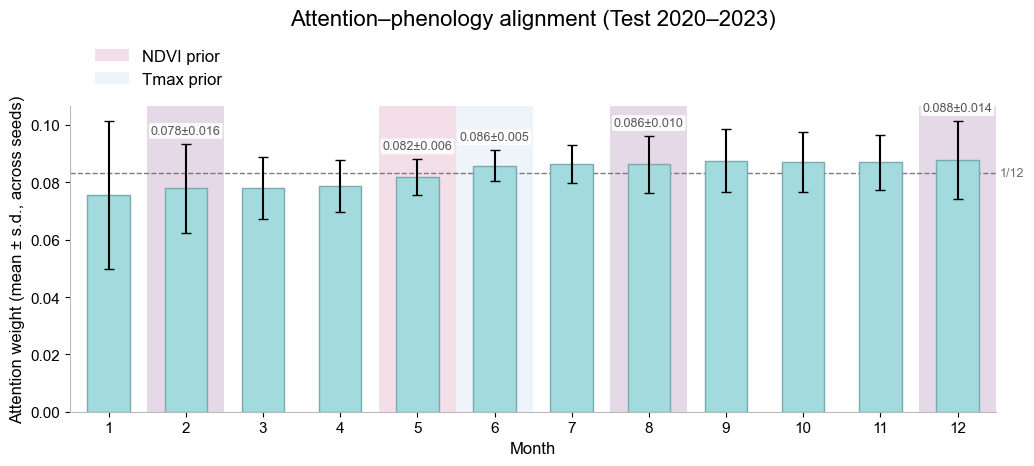

In [ ]:
# -*- coding: utf-8 -*-
# make_attention_phenology_alignment.py
# Compatible model loading + attention extraction + publication-quality visualization (white background, no grid, narrow bars, baseline and prior annotation)

import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, concatenate,
    Activation, Multiply, Lambda, LayerNormalization
)
from tensorflow.keras import Model, backend as K, regularizers

# ---------------- Basic Configuration ----------------
DATA_PATH    = "../data/lstm_input_states_cleaned.csv"
MODEL_DIR    = "../results/paper_compare_timeaware_anomaly"
MODEL_PATTERN= "best_lstm64_att_seed*.h5"   # Change to *.keras if using .keras format
OUT_DIR      = Path("../results/attention_alignment_plots")
OUT_DIR.mkdir(parents=True, exist_ok=True)

STATIC_COLS = ["ph","ocd","clay","sand","silt","bd","irr_flag"]

# —— Prior "keep months" consistent with the paper —— #
KEEP_NDVI_MONTHS   = {2, 5, 8, 12}
KEEP_TMAX_MONTHS   = {2, 6, 8, 12}
KEEP_PRECIP_MONTHS = set(range(1, 13))

TRAIN_YEARS = list(range(2000, 2017))
VALID_YEARS = [2017, 2018, 2019]
TEST_YEARS  = [2020, 2021, 2022, 2023]

# ---------------- Constructor consistent with training ----------------
def detect_precip_prefix(columns):
    if "precip_01" in columns or "precip_1" in columns: return "precip"
    if "prcp_01"   in columns or "prcp_1"   in columns: return "prcp"
    return "precip"

def col_real(prefix, m, columns):
    mm = f"{m:02d}"
    c1, c2 = f"{prefix}_{mm}", f"{prefix}_{m}"
    if c1 in columns: return c1
    if c2 in columns: return c2
    raise ValueError(f"Missing column: {prefix}_{mm}/{prefix}_{m}")

def cols_12(prefix, columns): 
    return [col_real(prefix, m, columns) for m in range(1,13)]

def apply_keep_and_mask(df, prefix, keep_months):
    for m in range(1,13):
        val_col  = col_real(prefix, m, df.columns)
        mask_col = f"{prefix}_mask_{m:02d}"
        keep = 1 if m in keep_months else 0
        df[mask_col] = keep
        if keep == 0: 
            df[val_col] = 0.0

def build_sequence_by_month(df, precip_prefix):
    cols = []
    for m in range(1,13):
        cols += [col_real("ndvi", m, df.columns),  f"ndvi_mask_{m:02d}",
                 col_real("tmax", m, df.columns),  f"tmax_mask_{m:02d}",
                 col_real(precip_prefix, m, df.columns), f"{precip_prefix}_mask_{m:02d}"]
    X = df[cols].values.astype(np.float32)
    return X.reshape(-1, 12, 6)

def additive_attention(inputs, name="att"):
    # inputs: (batch, time, hidden) -> context, alpha
    e = Dense(1, activation="tanh", name=f"{name}_energy")(inputs)
    e = Lambda(lambda x: K.squeeze(x, axis=-1), name=f"{name}_squeeze")(e)     # (b,t)
    alpha = Activation("softmax", name=f"{name}_weights")(e)                    # (b,t)
    alpha_exp = Lambda(lambda x: K.expand_dims(x, axis=-1), name=f"{name}_expand")(alpha)
    context = Multiply(name=f"{name}_mul")([inputs, alpha_exp])
    context = Lambda(lambda x: K.sum(x, axis=1), name=f"{name}_context")(context)
    return context, alpha

def build_lstm64_att_skeleton(n_static: int) -> Model:
    reg = regularizers.l2(1e-5)
    seq_in = Input(shape=(12,6), name="seq_input")
    h = LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.10,
             kernel_regularizer=reg, recurrent_regularizer=reg, name="lstm")(seq_in)
    h = LayerNormalization(name="ln1")(h)
    ctx, _ = additive_attention(h, name="att")   # Generates att_weights layer
    x = LayerNormalization(name="ln2")(ctx)
    x = Dropout(0.2, name="drop_ctx")(x)
    sta_in = Input(shape=(n_static,), name="static_input")
    z = concatenate([x, sta_in], name="concat")
    z = Dense(64, activation="relu", kernel_regularizer=reg, name="head_dense")(z)
    z = Dropout(0.2, name="head_drop")(z)
    out = Dense(1, name="out")(z)
    return Model([seq_in, sta_in], out, name="lstm64_att")

def get_attention_extractor(model: tf.keras.Model) -> tf.keras.Model:
    # First try to get explicitly named attention weights
    try:
        w = model.get_layer("att_weights").output
    except Exception:
        # Auto-search: softmax activation and tensor of length 12
        w = None
        for lyr in model.layers:
            try:
                cfg = lyr.get_config()
                if isinstance(cfg, dict) and cfg.get("activation","") == "softmax":
                    out = lyr.output
                    shp = tuple(out.shape.as_list())
                    if (len(shp)==2 and shp[1]==12) or (len(shp)==3 and shp[-2]==12):
                        w = out
                        break
            except Exception:
                continue
        if w is None:
            raise RuntimeError("Attention weights layer (att_weights or softmax@12) not found in model.")
    # Flatten to (batch, 12)
    if len(w.shape) == 3 and int(w.shape[-1]) == 1:
        w = Lambda(lambda x: x[...,0], name="att_squeeze")(w)
    return tf.keras.Model(model.inputs, w, name="att_extractor")

# ---------------- Read data and split test set ----------------
df = pd.read_csv(DATA_PATH)
assert {"year","state","yield"}.issubset(df.columns)
df["year"]  = df["year"].astype(int)
df["state"] = df["state"].astype(str)

precip_prefix = detect_precip_prefix(df.columns)
apply_keep_and_mask(df, "ndvi",        KEEP_NDVI_MONTHS)
apply_keep_and_mask(df, "tmax",        KEEP_TMAX_MONTHS)
apply_keep_and_mask(df, precip_prefix, KEEP_PRECIP_MONTHS)

seq_value_cols = cols_12("ndvi", df.columns) + cols_12("tmax", df.columns) + cols_12(precip_prefix, df.columns)
mask_cols = [f"ndvi_mask_{m:02d}" for m in range(1,13)] + \
            [f"tmax_mask_{m:02d}" for m in range(1,13)] + \
            [f"{precip_prefix}_mask_{m:02d}" for m in range(1,13)]
keep_cols = seq_value_cols + mask_cols + STATIC_COLS + ["yield","state","year"]
df = df[keep_cols].dropna(subset=["yield"]).copy()
df[seq_value_cols + mask_cols + STATIC_COLS] = df[seq_value_cols + mask_cols + STATIC_COLS].fillna(0.0)

in_test  = df["year"].isin(TEST_YEARS)
X_seq_all= build_sequence_by_month(df, precip_prefix)
X_sta_all= df[STATIC_COLS].values.astype(np.float32) if STATIC_COLS else np.zeros((len(df),0), np.float32)

X_seq_te  = X_seq_all[in_test]
X_sta_te  = X_sta_all[in_test]
years_te  = df.loc[in_test, "year"].values
states_te = df.loc[in_test, "state"].values

print(f"[INFO] Test set: n={len(years_te)}, years={sorted(set(years_te))}, states={len(set(states_te))}")

# ---------------- Compatible loader ----------------
def load_model_and_extract_att(path, n_static):
    """
    Compatible loader for lstm64_att:
    - Handle unary operations '_pos' / 'pos' in Lambda
    - First try keras3 saving, then tf.keras, finally skeleton+by_name
    """
    def _identity(x): return x
    tf_ops = getattr(tf, "__operators__", None)
    pos_op = getattr(tf_ops, "pos", None) if tf_ops is not None else None
    POS = pos_op if callable(pos_op) else _identity

    custom = {"_pos": POS, "pos": POS, "tf.__operators__.pos": POS}

    # A) keras3
    try:
        import keras
        mdl = keras.saving.load_model(path, compile=False, safe_mode=False, custom_objects=custom)
        return get_attention_extractor(mdl)
    except Exception as e:
        print(f"[WARN] Method A failed (keras.saving): {e}")

    # B) tf.keras
    try:
        mdl = tf.keras.models.load_model(path, compile=False, custom_objects=custom)
        return get_attention_extractor(mdl)
    except Exception as e:
        print(f"[WARN] Method B failed (tf.keras.load_model): {e}")

    # C) skeleton + by_name
    try:
        skel = build_lstm64_att_skeleton(n_static)
        skel.load_weights(path, by_name=True, skip_mismatch=True)
        return get_attention_extractor(skel)
    except Exception as e:
        raise RuntimeError(f"Method C failed (skeleton+load_weights): {e}")

# ---------------- Scan all seeds and extract attention ----------------
paths = sorted(glob.glob(os.path.join(MODEL_DIR, MODEL_PATTERN)))
if len(paths)==0:
    raise FileNotFoundError(f"Model not found: {os.path.join(MODEL_DIR, MODEL_PATTERN)}")

att_list, seed_ids = [], []
for p in paths:
    try:
        extractor = load_model_and_extract_att(p, n_static=X_sta_te.shape[1])
        if isinstance(extractor.input, (list, tuple)):
            att = extractor.predict([X_seq_te, X_sta_te], verbose=0)
        else:
            att = extractor.predict(X_seq_te, verbose=0)
        att = np.array(att)
        if att.ndim==3 and att.shape[-1]==1: 
            att = att[...,0]
        assert att.shape[1]==12, f"Unexpected attention dimension: {att.shape}"
        att_list.append(att)

        m = re.search(r"seed(\d+)", os.path.basename(p))
        seed_ids.append(int(m.group(1)) if m else len(seed_ids))
        print(f"[OK] {os.path.basename(p)} -> {att.shape}")
    except Exception as e:
        print(f"[WARN] Skipping {p}: {e}")

if len(att_list) == 0:
    raise RuntimeError("Failed to extract attention from any model.")

ATT = np.stack(att_list, axis=0)  # (n_seed, n_test, 12)
seed_ids = np.array(seed_ids)

# ---------------- Summary ----------------
# First average over test samples per month, then average/std over seeds (=statistics across seeds)
month_mean_per_seed = ATT.mean(axis=1)           # (n_seed, 12)
month_mean = month_mean_per_seed.mean(axis=0)
month_sd   = month_mean_per_seed.std(axis=0, ddof=1)

pd.DataFrame({"month":np.arange(1,13),"att_mean":month_mean,"att_sd":month_sd}) \
  .to_csv(OUT_DIR/"attention_by_month_mean_sd.csv", index=False)

# ---------------- Plotting (white background, no grid, narrow bars) ----------------
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlepad": 10,
})

from matplotlib.patches import Patch

# Colors (as requested)
# Bar RGB(162,218,222)
BAR_FACE = (162/255, 218/255, 222/255, 1.0)
BAR_EDGE = (120/255, 170/255, 174/255, 1.0)  # Slightly darker border
# NDVI prior shade: RGB(197,78,136)
NDVI_SHADE = (197/255, 78/255, 136/255, 0.18)
# Tmax prior shade: RGB(162,194,226)
TMAX_SHADE = (162/255, 194/255, 226/255, 0.18)

def shade_prior(ax):
    for m in sorted(KEEP_NDVI_MONTHS):
        ax.axvspan(m-0.5, m+0.5, color=NDVI_SHADE, lw=0, zorder=0)
    for m in sorted(KEEP_TMAX_MONTHS):
        ax.axvspan(m-0.5, m+0.5, color=TMAX_SHADE, lw=0, zorder=0)

months = np.arange(1,13)
fig, ax = plt.subplots(figsize=(10.5, 6.2))
shade_prior(ax)

# —— Dashed baseline: uniform attention 1/12 —— #
uniform = 1.0/12.0
ax.axhline(uniform, ls="--", lw=1.0, color="#6E6E6E", alpha=0.9, zorder=1)
ax.text(12.55, uniform, "1/12", va="center", ha="left", fontsize=9, color="#6E6E6E")

# —— Bars + error bars (narrower) —— #
BAR_W = 0.55   # Can be changed to 0.50 / 0.45 for even narrower bars
ax.bar(
    months, month_mean, yerr=month_sd, capsize=3.8, width=BAR_W,
    color=BAR_FACE, edgecolor=BAR_EDGE, linewidth=1.0, zorder=2
)

# Small gray text above prior months: mean±sd
prior_union = sorted(KEEP_NDVI_MONTHS | KEEP_TMAX_MONTHS)
for m in prior_union:
    mu, sd = month_mean[m-1], month_sd[m-1]
    ax.annotate(f"{mu:.3f}±{sd:.3f}",
                xy=(m, mu + sd),
                xytext=(0, 5), textcoords="offset points",
                ha="center", va="bottom",
                fontsize=9, color="#555555",
                bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.9),
                clip_on=False)

# Axes and title
ax.set_xticks(months); ax.set_xlim(0.5, 12.5)
ax.set_xlabel("Month")
ax.set_ylabel("Attention weight (mean ± s.d., across seeds)")
ax.set_title("Attention–phenology alignment (Test 2020–2023)", y=1.22)

# White background, no grid (only baseline remains)
ax.grid(False)

# Move legend to top left above plot
ax.legend(
    handles=[
        Patch(facecolor=NDVI_SHADE, edgecolor="none", label="NDVI prior"),
        Patch(facecolor=TMAX_SHADE, edgecolor="none", label="Tmax prior"),
    ],
    frameon=False, loc="upper left", bbox_to_anchor=(0.02, 1.21), borderaxespad=0.0
)

# Ensure enough top margin to avoid clipping
fig.tight_layout(rect=(0, 0.02, 1, 0.86))

# Save figures
fig.savefig(OUT_DIR/"att_by_month_mean_sd.png", dpi=320)
fig.savefig(OUT_DIR/"att_by_month_mean_sd.pdf")

print(f"[DONE] Saved to {OUT_DIR.resolve()}")